In [ ]:
# This is code from ~2016-2018.
# It is used to carry out an MCMC (emcee) in order to estimate the parameters of a biconical outflow.
# The input is the velocity and velocity error of the two components of a double-peaked profile.
# The output is the position of the walkers at various points in time.
# The parameters of the bicone are phi, the inclination, theta, the PA on the sky, r_t, the turnover radius
# for the velocity law, the half opening angle and the maximum velocity.
# I've rewritten it to more generally apply to any grid you place over it.
# ~~~~~~~~~~~~~~~~~~~~~~~~~
                                                                                                                                                                                     
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
#from astropy.modeling import models, fitting                                                                                                                                                      
from pylab import *
import math
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.gridspec as grid_spec
from sklearn.neighbors import KernelDensity


def order_points(pts):
        # initialize a list of coordinates that will be ordered                                                                                                                                            
        # such that the first entry in the list is the top-left,                                                                                                                                           
        # the second entry is the top-right, the third is the                                                                                                                                              
        # bottom-right, and the fourth is the bottom-left                                                                                                                                                  
        rect = np.zeros((4, 2), dtype="float32")
        # the top-left point will have the smallest sum, whereas                                                                                                                                           
        # the bottom-right point will have the largest sum                                                                                                                                                 
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        # now, compute the difference between the points, the                                                                                                                                              
        # top-right point will have the smallest difference,                                                                                                                                               
        # whereas the bottom-left will have the largest difference                                                                                                                                         
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        # return the ordered coordinates                                                                                                                                                                   
        return rect

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TIME TO DO THE BICONE                                                                                                                                            






# These fxns construct the various bicones based on the input parameters
# The output is the 3-dimensional construction of x, y, and z coordinates and the LOS velocity
# at that point.

# There are three different 'construction' fxns, one for the bicone,
# one for the cocone, and one for the nesting cone, all of which
# have different geometries, see Nevin et al. 2018 for more
# details about how I build these.




# This code constructs a three dimensional bicone that will be fed into lnlike_bicone 
# where it will be projected down to 2D
def bicone_construction_plot(bounds, phi,theta,r_t, half_angle, vel_max, verbose, xs_proj, ys_proj,name):
    #print('these are the input parameters',phi,theta,r_t, half_angle, vel_max)
    # the five input parameters determine the geometry of the bicone,
    # phi is the inclination, theta, is the position angle on the sky in 2D,
    # r_t is the turnover radius, or point at which the material moving along
    # the walls begins to decelerate,
    # half_angle, is the half opening angle,
    # and vel_max is the maximum intrinsic (meaning 3D) velocity along the walls
    # of the cone.
    
    # The model only moves material along the walls of the cone, so it could
    # be called an 'evacuated bicone'
    
    half_angle_r=math.radians(half_angle)
    phi_1=math.radians(phi)
    theta_1=math.radians(theta)
    psi_1=math.radians(0)

    # the total heigh is twice the effective radius because
    # the velocity decays linearly from vmax to zero
    h=2*r_t
    # to get the radius of the cone, you need to do some trig
    # this is the radius across the opening
    r=math.tan(half_angle_r)*h
    
    # this is your sampling around the cone, here I'm taking 50 points
    theta_para=(np.asarray(np.linspace(0,2*np.pi,75)))
    
    # This is the sampling along the heigh of the cone
    u1_orig=np.asarray(np.linspace(-h,0,60))+h#
    u2_orig=-np.asarray(np.linspace(-h,0,60))-h
    u=-np.asarray(np.linspace(-h,0,60))

    


    

    #R is the rotation matrix
    R=np.matrix([[np.cos(theta_1)*np.cos(psi_1),np.cos(phi_1)*np.sin(psi_1)+np.sin(phi_1)*np.sin(theta_1)*np.cos(psi_1),
                  np.sin(phi_1)*np.sin(psi_1)-np.cos(phi_1)*np.sin(theta_1)*np.cos(psi_1)],
                     [-np.cos(theta_1)*np.sin(psi_1),
                      np.cos(phi_1)*np.cos(psi_1)-np.sin(phi_1)*np.sin(theta_1)*np.sin(psi_1),
                      np.sin(phi_1)*np.cos(psi_1)+np.cos(phi_1)*np.sin(theta_1)*np.sin(psi_1)],
                     [np.sin(theta_1), -np.sin(phi_1)*np.cos(theta_1), np.cos(phi_1)*np.cos(theta_1)]])
    #x is going to be the front facing side (blueshifted) and x_2 is the rear cone
    x=[]
    x_2=[]
    y=[]
    y_2=[]
    z=[]
    z_2=[]
    
    vel_radial_bottom=[]
    vel_radial_top=[]
    
    x_totes=[]
    y_totes=[]
    z_totes=[]
    x_plane=[]
    y_plane=[]
    z_plane=[]
    x_plane_2=[]
    y_plane_2=[]
    z_plane_2=[]
    
    if verbose=='yes':
        from mpl_toolkits import mplot3d

        plt.clf()
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(0,0,0,marker='*', color='orange')
    
    for i in range(len(theta_para)):
        for j in range(len(u)):
            if i==0:
                i=1
            if j==0:
                j=1

            #here's the parametric equation for a bicone
            X=((h-u[j])*r*np.cos((theta_para[i])))/h
            Y=((h-u[j])*r*np.sin((theta_para[i])))/h

          

            #blue cone above is Z_1
            #red cone below is Z_2
            Z_1=u2_orig[j]#was u2
            Z_2=u1_orig[j]#was u1
            
            
            
            y_plane_into=0

            pos=np.matrix([X,Y,Z_1])
            pos_2=np.matrix([X,Y,Z_2])
            
            # so the 'plane' positions are all at y=0, because they are projected
            # onto the plane of the sky
            pos_plane=np.matrix([X,y_plane_into,Z_1])
            pos_plane_2=np.matrix([X,y_plane_into, Z_2])
            
            # take the dot product of the rotation matrix and the current position
            # in order to move to the location on the cone
            new_pos=np.dot(R,pos.transpose())
            new_pos_2=np.dot(R,pos_2.transpose())
            new_pos_plane=np.dot(R,pos_plane.transpose())
            x_plane.append(new_pos_plane[0])
            
            y_plane.append(new_pos_plane[1])
            z_plane.append(new_pos_plane[2])
            new_pos_plane_2=np.dot(R, pos_plane_2.transpose())
            x_plane_2.append(new_pos_plane_2[0])
            y_plane_2.append(new_pos_plane_2[1])
            z_plane_2.append(new_pos_plane_2[2])
            
            
            #Z_2=u1[j]
            x.append(new_pos[0])
            x_2.append(new_pos_2[0])
            y.append(new_pos[1])
            y_2.append(new_pos_2[1])
            
            z.append(new_pos[2])
            z_2.append(new_pos_2[2])
            
            
            if np.sqrt(np.array(new_pos[0]).ravel()**2+np.array(new_pos[1]).ravel()**2+np.array(new_pos[2]).ravel()**2)<r_t:
                # so if the point is at a distance less than the turnover radius, then the velocity is the max velocity
                vel_max_top=-vel_max
            if np.sqrt(np.array(new_pos[0]).ravel()**2+np.array(new_pos[1]).ravel()**2+np.array(new_pos[2]).ravel()**2)>r_t:
                # if the point is greater than the turnover radius, then it will decline linearly to zero at 2*r_t
                vel_max_top=-(vel_max-(vel_max/r_t)*(np.sqrt(np.array(new_pos[0]).ravel()**2+np.array(new_pos[1]).ravel()**2+np.array(new_pos[2]).ravel()**2)-r_t))
                
            if np.sqrt(np.array(new_pos[0]).ravel()**2+np.array(new_pos[1]).ravel()**2+np.array(new_pos[2]).ravel()**2)>2*r_t:
                # if the point is farther than 2*r_t, then it is already at zero
                vel_max_top=0
            #do that thing:
            #equation: d/dw/e((x^2 + y^2)/c^2 = (z-z_0)^2)
            #recall c=r/h
            #<2*x,2*y,-(2*r^2*z)/h^2>
            #plug in everything and normalize and then the z component is your v_rad
    
            # Time to project this velocity into a line of sight velocity
            slope_x=np.array(new_pos[0]).ravel()#eliminated 2*
            slope_y=np.array(new_pos[1]).ravel()# eliminated 2*
            slope_z=np.array(new_pos[2]).ravel()#-(2*r**2*np.array(new_pos[2]).ravel())/h**2
            
            norm=np.sqrt(slope_x**2+slope_y**2+slope_z**2)
            A_comp=-(slope_y/norm)
            if verbose=='yes':
                ax.plot3D([slope_x,0],[slope_y,0],[slope_z,0])
            
            
            # multiply the intrinsic velocity by the component of A that is in the y direction
            # y, which is the line of sight direction
            # currently, the velocity is projected along the wall of the bicone
            rad_proj=vel_max_top*np.array(A_comp).ravel()
            
            
            #print('position', new_pos)
            #print('total length to x,y,z = 0', norm, 'y cont', slope_y)
            #print('velocity at this point', vel_max_top)
            #print('component', *np.array(A_comp).ravel())
            #print('projected vel', rad_proj)
            
            vel_radial_top.append(round(rad_proj[0]))
            
            slope_x=2*np.array(new_pos_2[0]).ravel()
            slope_y=2*np.array(new_pos_2[1]).ravel()
            
            slope_z_2=-(2*r**2*np.array(new_pos_2[2]).ravel())/h**2
            norm=np.sqrt(slope_x**2+slope_y**2+slope_z_2**2)
            
            if np.sqrt(np.array(new_pos_2[0]).ravel()**2+np.array(new_pos_2[1]).ravel()**2+np.array(new_pos_2[2]).ravel()**2)<r_t:
                
            
#                vel_max_bottom=-(vel_max/r_t)*np.sqrt(new_pos_2[0]**2+new_pos_2[1]**2+new_pos_2[2]**2)
                vel_max_bottom=-vel_max
            if np.sqrt(np.array(new_pos_2[0]).ravel()**2+np.array(new_pos_2[1]).ravel()**2+np.array(new_pos_2[2]).ravel()**2)>r_t:
                #vel_max_bottom=vel_max-(vel_max/r_t)*np.sqrt(new_pos_2[0]**2+new_pos_2[1]**2+new_pos_2[2]**2)
                vel_max_bottom=-(vel_max-(vel_max/r_t)*(np.sqrt(np.array(new_pos[0]).ravel()**2+np.array(new_pos[1]).ravel()**2+np.array(new_pos[2]).ravel()**2)-r_t))
                #if new_pos_2[2]>0:
                #    vel_max_bottom=-vel_max_bottom
                #if vel_max_bottom>0:
                #    vel_max_bottom=0
            if np.sqrt(np.array(new_pos_2[0]).ravel()**2+np.array(new_pos_2[1]).ravel()**2+np.array(new_pos_2[2]).ravel()**2)>2*r_t:
                #vel_max_bottom=vel_max-(vel_max/r_t)*np.sqrt(new_pos_2[0]**2+new_pos_2[1]**2+new_pos_2[2]**2)
                vel_max_bottom=0
            #if abs(vel_max_bottom)>1001:
            #    vel_max_bottom=0
            #A dot x should give us the vector projection along x - divide by the magnitude of A to get cos (theta)
            A_comp=-(slope_y/norm)
            
            
            
            rad_proj_2=np.array(A_comp).ravel()*vel_max_bottom
            vel_radial_bottom.append(round(rad_proj_2[0]))
    if verbose=='yes':
        # planes at x=0, y=0, and z=0 to guide the eye
        xx, zz = np.meshgrid(range(-20,20), range(-20,20))
        im = ax.scatter3D(x, y, z, c=vel_radial_top, cmap='Blues_r')
        im2 = ax.scatter3D(x_2,y_2,z_2,c=vel_radial_bottom, cmap='Reds')
        # calculate corresponding z
        yy = [0 for x in xx]
        ax.plot_surface(xx, yy, zz, alpha=0.2)
        #ax.set_ylim([-20,0])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(azim=0)
        plt.colorbar(im)
        plt.colorbar(im2)
        plt.savefig('3D_diag_'+str(name)+'.png')
    
    
    # So the first half of all these merged arrays is the blueshifted side of the cone (above the plane of the sky)
    # and x_2, etc are the redshifted, or 'bottom' side of the cone.
    merged_x=x+x_2
    merged_y=y+y_2
    merged_z=z+z_2
    
    merged_x_plane=x_plane+x_plane_2
    merged_y_plane=y_plane+y_plane_2
    merged_z_plane=z_plane+z_plane_2
    
    
    
    merged_vel=vel_radial_top+vel_radial_bottom
    
    if verbose=='yes':
        '''plt.clf()
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        im = ax.scatter3D(merged_x_plane, merged_y_plane, merged_z_plane, c=merged_vel, cmap='RdBu_r')
        plt.colorbar(im)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.plot_surface(xx, yy, zz, alpha=0.2)
        ax.view_init(azim=10)

        plt.savefig('3D_merged_plane_'+str(name)+'.png')

        plt.clf()
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        im = ax.scatter3D(merged_x, merged_y, merged_z, c=merged_vel, cmap='RdBu_r')
        plt.colorbar(im)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.plot_surface(xx, yy, zz, alpha=0.2)
        ax.view_init(azim=10)
        plt.savefig('3D_merged_'+str(name)+'.png')
        
        sns.set_style("dark")
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        new_merged_x = []
        new_merged_z = []
        for j in range(np.shape(merged_x)[0]):
            new_merged_x.append(np.array(merged_x)[j][0][0])
            new_merged_z.append(np.array(merged_z)[j][0][0])
            
        im = ax.scatter(new_merged_x, new_merged_z, c=merged_vel, cmap=get_SauronCmap(), alpha = 0.5, s=1)
        for n in range(np.shape(xs_proj)[0]):
            ax.scatter(xs_proj[n], ys_proj[n], color='white',edgecolor = 'black', s=1)
        ax.set_aspect('equal')
        plt.colorbar(im, label='Line of sight velocity')
        ax.set_ylabel('Position in Arcsec')
        ax.set_aspect(aspect=1)
        plt.savefig('overplot_data_model_'+str(name)+'.png', dpi=1000)'''
        
        # Fuck, I need to figure out how to split
        # the cone by the y plane, which needs to be inclined and
        # rotated
        
        
        sns.set_context("talk")
        sns.set_style("white")
        plt.clf()
        fig = plt.figure(figsize = (20,15))
        ax = fig.add_subplot(121)
        new_merged_x = []
        new_merged_z = []
        vel_radial = []
        for j in range(np.shape(merged_x)[0]):
            if np.array(merged_y)[j][0][0] < 0:
                new_merged_x.append(np.array(merged_x)[j][0][0])
                new_merged_z.append(np.array(merged_z)[j][0][0])
                vel_radial.append(merged_vel[j])
         
        
        # Create grid values first.
        import matplotlib.tri as tri
        ngridx = 200
        ngridy = 200
        xi = np.linspace(min(new_merged_x), max(new_merged_x), ngridx)
        yi = np.linspace(min(new_merged_z), max(new_merged_z), ngridy)

        # Perform linear interpolation of the data (x,y)
        # on a grid defined by (xi,yi)
        triang = tri.Triangulation(new_merged_x, new_merged_z)
        interpolator = tri.LinearTriInterpolator(triang, vel_radial)
        Xi, Yi = np.meshgrid(xi, yi)
        zi = interpolator(Xi, Yi)

        # Note that scipy.interpolate provides means to interpolate data on a grid
        # as well. The following would be an alternative to the four lines above:
        #from scipy.interpolate import griddata
        #zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')


        #ax.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
        levels = np.linspace(np.min(zi), np.max(zi), 100)#[-250, -200, -150, -100,-50, -25]
        cntr1 = ax.contourf(xi, yi, zi, levels=levels, cmap="Blues_r", alpha=0.5)
        
        im = ax.scatter(new_merged_x, new_merged_z, 
                        c=vel_radial, cmap='Blues_r', s=2)
        
        for n in range(np.shape(xs_proj)[0]):
            #ax.scatter(xs_proj[n], ys_proj[n], color='white',edgecolor = 'black', s=1)
            
            for t in range(len(xs_proj[n])):
                #bound of pt 1 (1, 58, 4, 2)
                if t==0 or t==int(len(xs_proj[n])/2) or xs_proj[n][t]==0:
                    ax.annotate(str(round(np.sqrt(xs_proj[n][t]**2+ys_proj[n][t]**2),2))+'$^{\prime\prime}$', 
                        xy = (xs_proj[n][t]+0.5, ys_proj[n][t]+0.2),xycoords='data')
                poly = list(bounds[n][t])
                poly.append(poly[0]) #repeat the first point to create a 'closed loop'

                xs, ys = zip(*poly) #create lists of x and y values
                ax.plot(xs, ys, color='black')
        ax.set_aspect('equal')
        plt.colorbar(im, fraction = 0.046)#, label='Line of sight velocity')
        ax.set_ylabel('Position in Arcsec')
        ax.set_xlabel('Position in ARcsec')
        ax.set_aspect(aspect=1)
        ax.set_title('Approaching', size=30)
        
        
        
        ax2 = fig.add_subplot(122)
        new_merged_x = []
        new_merged_z = []
        vel_radial = []
        for j in range(np.shape(merged_x)[0]):
            if np.array(merged_y)[j][0][0] > 0:
                new_merged_x.append(np.array(merged_x)[j][0][0])
                new_merged_z.append(np.array(merged_z)[j][0][0])
                vel_radial.append(merged_vel[j])
            
        
        # Create grid values first.
        import matplotlib.tri as tri
        ngridx = 200
        ngridy = 200
        xi = np.linspace(min(new_merged_x), max(new_merged_x), ngridx)
        yi = np.linspace(min(new_merged_z), max(new_merged_z), ngridy)

        # Perform linear interpolation of the data (x,y)
        # on a grid defined by (xi,yi)
        triang = tri.Triangulation(new_merged_x, new_merged_z)
        interpolator = tri.LinearTriInterpolator(triang, vel_radial)
        Xi, Yi = np.meshgrid(xi, yi)
        zi = interpolator(Xi, Yi)

        # Note that scipy.interpolate provides means to interpolate data on a grid
        # as well. The following would be an alternative to the four lines above:
        #from scipy.interpolate import griddata
        #zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')


        levels = np.linspace(np.min(zi), np.max(zi),  100)
        cntr2 = ax2.contourf(xi, yi, zi, levels=levels, cmap="Reds", alpha=0.5)
        
        
        
        for n in range(np.shape(xs_proj)[0]):
            #ax2.scatter(xs_proj[n], ys_proj[n], color='white',edgecolor = 'black', s=1)
            for t in range(len(xs_proj[n])):
                #bound of pt 1 (1, 58, 4, 2)
                
                poly = list(bounds[n][t])
                poly.append(poly[0]) #repeat the first point to create a 'closed loop'

                xs, ys = zip(*poly) #create lists of x and y values
                ax2.plot(xs, ys, color='black')
        im2 = ax2.scatter(new_merged_x, new_merged_z, c=vel_radial, cmap='Reds', s=4)
        
        ax2.set_aspect('equal')
        plt.colorbar(im2, label='Line of sight velocity', fraction = 0.046)
        ax2.set_aspect(aspect=1)
        ax2.set_title('Receding', size=30)
        
        plt.savefig('overplot_data_model_two_'+str(name)+'.png', dpi=500)
    
    
    return merged_x, merged_y, merged_z, merged_vel, merged_x_plane, merged_y_plane, merged_z_plane

# This is the lean version for the emcee
def bicone_construction(phi,theta,r_t, half_angle, vel_max):
    
    
    half_angle_r=math.radians(half_angle)
    phi_1=math.radians(phi)
    theta_1=math.radians(theta)
    psi_1=math.radians(0)

    # the total heigh is twice the effective radius because
    # the velocity decays linearly from vmax to zero
    h=2*r_t
    # to get the radius of the cone, you need to do some trig
    # this is the radius across the opening
    r=math.tan(half_angle_r)*h
    
    # this is your sampling around the cone, here I'm taking 50 points
    theta_para=(np.asarray(np.linspace(0,2*np.pi,50)))
    
    # This is the sampling along the heigh of the cone
    u1_orig=np.asarray(np.linspace(-h,0,30))+h#
    u2_orig=-np.asarray(np.linspace(-h,0,30))-h
    u=-np.asarray(np.linspace(-h,0,30))


    

    #R is the rotation matrix
    R=np.matrix([[np.cos(theta_1)*np.cos(psi_1),np.cos(phi_1)*np.sin(psi_1)+np.sin(phi_1)*np.sin(theta_1)*np.cos(psi_1),
                  np.sin(phi_1)*np.sin(psi_1)-np.cos(phi_1)*np.sin(theta_1)*np.cos(psi_1)],
                     [-np.cos(theta_1)*np.sin(psi_1),
                      np.cos(phi_1)*np.cos(psi_1)-np.sin(phi_1)*np.sin(theta_1)*np.sin(psi_1),
                      np.sin(phi_1)*np.cos(psi_1)+np.cos(phi_1)*np.sin(theta_1)*np.sin(psi_1)],
                     [np.sin(theta_1), -np.sin(phi_1)*np.cos(theta_1), np.cos(phi_1)*np.cos(theta_1)]])
    #x is going to be the front facing side (blueshifted) and x_2 is the rear cone
    x=[]
    x_2=[]
    y=[]
    y_2=[]
    z=[]
    z_2=[]
    
    vel_radial_bottom=[]
    vel_radial_top=[]
    
    x_totes=[]
    y_totes=[]
    z_totes=[]
    x_plane=[]
    y_plane=[]
    z_plane=[]
    x_plane_2=[]
    y_plane_2=[]
    z_plane_2=[]
    
    
    
    for i in range(len(theta_para)):
        for j in range(len(u)):
            if i==0:
                i=1
            if j==0:
                j=1

            #here's the parametric equation for a bicone
            X=((h-u[j])*r*np.cos((theta_para[i])))/h
            Y=((h-u[j])*r*np.sin((theta_para[i])))/h

          

            #blue cone above is Z_1
            #red cone below is Z_2
            Z_1=u2_orig[j]#was u2
            Z_2=u1_orig[j]#was u1
            
            
            
            y_plane_into=0

            pos=np.matrix([X,Y,Z_1])
            pos_2=np.matrix([X,Y,Z_2])
            
            # so the 'plane' positions are all at y=0, because they are projected
            # onto the plane of the sky
            pos_plane=np.matrix([X,y_plane_into,Z_1])
            pos_plane_2=np.matrix([X,y_plane_into, Z_2])
            
            # take the dot product of the rotation matrix and the current position
            # in order to move to the location on the cone
            new_pos=np.dot(R,pos.transpose())
            new_pos_2=np.dot(R,pos_2.transpose())
            new_pos_plane=np.dot(R,pos_plane.transpose())
            x_plane.append(new_pos_plane[0])
            
            y_plane.append(new_pos_plane[1])
            z_plane.append(new_pos_plane[2])
            new_pos_plane_2=np.dot(R, pos_plane_2.transpose())
            x_plane_2.append(new_pos_plane_2[0])
            y_plane_2.append(new_pos_plane_2[1])
            z_plane_2.append(new_pos_plane_2[2])
            
            
            #Z_2=u1[j]
            x.append(new_pos[0])
            x_2.append(new_pos_2[0])
            y.append(new_pos[1])
            y_2.append(new_pos_2[1])
            
            z.append(new_pos[2])
            z_2.append(new_pos_2[2])
            
            
            if np.sqrt(np.array(new_pos[0]).ravel()**2+np.array(new_pos[1]).ravel()**2+np.array(new_pos[2]).ravel()**2)<r_t:
                # so if the point is at a distance less than the turnover radius, then the velocity is the max velocity
                vel_max_top=-vel_max
            if np.sqrt(np.array(new_pos[0]).ravel()**2+np.array(new_pos[1]).ravel()**2+np.array(new_pos[2]).ravel()**2)>r_t:
                # if the point is greater than the turnover radius, then it will decline linearly to zero at 2*r_t
                vel_max_top=-(vel_max-(vel_max/r_t)*(np.sqrt(np.array(new_pos[0]).ravel()**2+np.array(new_pos[1]).ravel()**2+np.array(new_pos[2]).ravel()**2)-r_t))
                
            if np.sqrt(np.array(new_pos[0]).ravel()**2+np.array(new_pos[1]).ravel()**2+np.array(new_pos[2]).ravel()**2)>2*r_t:
                # if the point is farther than 2*r_t, then it is already at zero
                vel_max_top=0
            #do that thing:
            #equation: d/dw/e((x^2 + y^2)/c^2 = (z-z_0)^2)
            #recall c=r/h
            #<2*x,2*y,-(2*r^2*z)/h^2>
            #plug in everything and normalize and then the z component is your v_rad
    
            # Time to project this velocity into a line of sight velocity
            slope_x=np.array(new_pos[0]).ravel()#eliminated 2*
            slope_y=np.array(new_pos[1]).ravel()# eliminated 2*
            slope_z=np.array(new_pos[2]).ravel()#-(2*r**2*np.array(new_pos[2]).ravel())/h**2
            
            norm=np.sqrt(slope_x**2+slope_y**2+slope_z**2)
            A_comp=-(slope_y/norm)
            
            # multiply the intrinsic velocity by the component of A that is in the y direction
            # y, which is the line of sight direction
            # currently, the velocity is projected along the wall of the bicone
            rad_proj=vel_max_top*np.array(A_comp).ravel()
            
            
            
            vel_radial_top.append(round(rad_proj[0]))
            
            slope_x=2*np.array(new_pos_2[0]).ravel()
            slope_y=2*np.array(new_pos_2[1]).ravel()
            
            slope_z_2=-(2*r**2*np.array(new_pos_2[2]).ravel())/h**2
            norm=np.sqrt(slope_x**2+slope_y**2+slope_z_2**2)
            
            if np.sqrt(np.array(new_pos_2[0]).ravel()**2+np.array(new_pos_2[1]).ravel()**2+np.array(new_pos_2[2]).ravel()**2)<r_t:
                
            
#                vel_max_bottom=-(vel_max/r_t)*np.sqrt(new_pos_2[0]**2+new_pos_2[1]**2+new_pos_2[2]**2)
                vel_max_bottom=-vel_max
            if np.sqrt(np.array(new_pos_2[0]).ravel()**2+np.array(new_pos_2[1]).ravel()**2+np.array(new_pos_2[2]).ravel()**2)>r_t:
                #vel_max_bottom=vel_max-(vel_max/r_t)*np.sqrt(new_pos_2[0]**2+new_pos_2[1]**2+new_pos_2[2]**2)
                vel_max_bottom=-(vel_max-(vel_max/r_t)*(np.sqrt(np.array(new_pos[0]).ravel()**2+np.array(new_pos[1]).ravel()**2+np.array(new_pos[2]).ravel()**2)-r_t))
                #if new_pos_2[2]>0:
                #    vel_max_bottom=-vel_max_bottom
                #if vel_max_bottom>0:
                #    vel_max_bottom=0
            if np.sqrt(np.array(new_pos_2[0]).ravel()**2+np.array(new_pos_2[1]).ravel()**2+np.array(new_pos_2[2]).ravel()**2)>2*r_t:
                #vel_max_bottom=vel_max-(vel_max/r_t)*np.sqrt(new_pos_2[0]**2+new_pos_2[1]**2+new_pos_2[2]**2)
                vel_max_bottom=0
            #if abs(vel_max_bottom)>1001:
            #    vel_max_bottom=0
            #A dot x should give us the vector projection along x - divide by the magnitude of A to get cos (theta)
            A_comp=-(slope_y/norm)
            
            
            
            rad_proj_2=np.array(A_comp).ravel()*vel_max_bottom
            vel_radial_bottom.append(round(rad_proj_2[0]))
     
    # So the first half of all these merged arrays is the blueshifted side of the cone (above the plane of the sky)
    # and x_2, etc are the redshifted, or 'bottom' side of the cone.
    merged_x=x+x_2
    merged_y=y+y_2
    merged_z=z+z_2
    
    merged_x_plane=x_plane+x_plane_2
    merged_y_plane=y_plane+y_plane_2
    merged_z_plane=z_plane+z_plane_2
    
    
    
    merged_vel=vel_radial_top+vel_radial_bottom
    
     
    
    return merged_x, merged_y, merged_z, merged_vel, merged_x_plane, merged_y_plane, merged_z_plane
                
    
            
# This creates a diagnostic plot by returning the 
def diagnostic_bicone_plot(z, xs_data_concat, xs_data_concat_ortho):


    #bicone_construction(h,phi,theta,r_t, half_angle )
    phi_array, theta_array, r_t,half_angle, vel_max_array=z


    h=2*r_t
    #h=[2*x for x in r_t]

    out=bicone_construction(phi_array, theta_array, r_t, half_angle, vel_max_array)

    # So this gives you a whole lot of 3D measurements that you do not actually need

    merged_x=[float(y) for y in out[0]]
    merged_y=[float(y) for y in out[1]]
    merged_z=[float(y) for y in out[2]]
    merged_vel=[float(y) for y in out[3]]
    merged_x_plane=[float(y) for y in out[4]]
    merged_y_plane=[float(y) for y in out[5]]
    merged_z_plane=[float(y) for y in out[6]]

    '''cone_red_x=[float(y) for y in out[7]]
    cone_red_y=[float(y) for y in out[8]]
    cone_red_z=[float(y) for y in out[9]]
    cone_blue_x=[float(y) for y in out[10]]
    cone_blue_y=[float(y) for y in out[11]]
    cone_blue_z=[float(y) for y in out[12]]
    cone_red_vel=[float(y) for y in out[13]]
    cone_blue_vel=[float(y) for y in out[14]]'''
    ##vel_radial_top actually refers to the stuff going away from us on the bottom -ugh
    #it's the projection looking down in z
    #p=ax.scatter(x_2,y_2,z_2, c=vel_radial_bottom)


    #%```````````````````````````````````
    #I'm going to make the phi cuts according to observe PAs
    PA_obs_1=np.radians(PA1+90)
    PA_obs_2=np.radians(PA2+90)

    '''x_slit_blue=np.linspace(-100*h,100*h, len(cone_blue_z))
    x_slit_red=np.linspace(-100*h,100*h,len(cone_red_z))'''
    
    x_slit=np.linspace(-100*h,100*h, len(merged_x))

    len_pts=max(upper_lim-lower_lim,upper_lim_ortho-lower_lim_ortho)

    #height is based upon the length of the overall data we have on the bicone and the slitwidth
    height=slitwidth/pixelscale_1#(slitwidth/(pixelscale*len_pts))#*(h)#I kinda want this to be a fraction of something else#10#was 4

    if PA1 < 90:
        z_slit_1_upper=[x*np.tan(PA_obs_1)-height/np.cos(PA_obs_1) for x in merged_x]
        z_slit_1_lower=[x*np.tan(PA_obs_1)+height/np.cos(PA_obs_1) for x in merged_x]
        
    else:
        z_slit_1_upper=[x*np.tan(PA_obs_1)+height/np.cos(PA_obs_1) for x in merged_x]
        z_slit_1_lower=[x*np.tan(PA_obs_1)-height/np.cos(PA_obs_1) for x in merged_x]
        
    height=slitwidth/pixelscale_2  
    if PA2 > 90:
        z_slit_2_upper=[x*np.tan(PA_obs_2)+height/np.cos(PA_obs_2) for x in merged_x]
        z_slit_2_lower=[x*np.tan(PA_obs_2)-height/np.cos(PA_obs_2) for x in merged_x]
        
    else: 
        z_slit_2_upper=[x*np.tan(PA_obs_2)-height/np.cos(PA_obs_2) for x in merged_x]
        z_slit_2_lower=[x*np.tan(PA_obs_2)+height/np.cos(PA_obs_2) for x in merged_x]
        
   

    if PA1<90:
        inds_1=np.logical_and(np.logical_and((np.asarray(merged_z) > np.asarray(z_slit_1_lower)), (np.asarray(merged_z) < np.asarray(z_slit_1_upper))), (np.asarray(merged_y) < np.asarray(merged_y_plane)))
        inds_1_below=np.logical_and(np.logical_and((np.asarray(merged_z) > np.asarray(z_slit_1_lower)), (np.asarray(merged_z) < np.asarray(z_slit_1_upper))), (np.asarray(merged_y) > np.asarray(merged_y_plane)))
    else:
        inds_1=np.logical_and(np.logical_and((np.asarray(merged_z) < np.asarray(z_slit_1_lower)), (np.asarray(merged_z) > np.asarray(z_slit_1_upper))), (np.asarray(merged_y) < np.asarray(merged_y_plane)))
        inds_1_below=np.logical_and(np.logical_and((np.asarray(merged_z) < np.asarray(z_slit_1_lower)), (np.asarray(merged_z) > np.asarray(z_slit_1_upper))), (np.asarray(merged_y) > np.asarray(merged_y_plane)))
    if PA2>90:
        inds_2=np.logical_and(np.logical_and((np.asarray(merged_z) < np.asarray(z_slit_2_lower)), (np.asarray(merged_z) > np.asarray(z_slit_2_upper))), (np.asarray(merged_y) < np.asarray(merged_y_plane)))
        inds_2_below=np.logical_and(np.logical_and((np.asarray(merged_z) < np.asarray(z_slit_2_lower)), (np.asarray(merged_z) > np.asarray(z_slit_2_upper))), (np.asarray(merged_y) > np.asarray(merged_y_plane)))
    else:
        inds_2=np.logical_and(np.logical_and((np.asarray(merged_z) > np.asarray(z_slit_2_lower)), (np.asarray(merged_z) < np.asarray(z_slit_2_upper))), (np.asarray(merged_y) < np.asarray(merged_y_plane)))
        inds_2_below=np.logical_and(np.logical_and((np.asarray(merged_z) > np.asarray(z_slit_2_lower)), (np.asarray(merged_z) < np.asarray(z_slit_2_upper))), (np.asarray(merged_y) > np.asarray(merged_y_plane)))
    

    '''xs_cont_1 is the blueshifted cone of PA1'''
    xs_cont_1=np.asarray(merged_x)[np.asarray(inds_1)]
    ys_cont_1=np.asarray(merged_y)[np.asarray(inds_1)]
    zs_cont_1=np.asarray(merged_z)[np.asarray(inds_1)]
    vel_cont_1=np.asarray(merged_vel)[np.asarray(inds_1)]

    '''xs_cont_1_below is the redshifted cone of PA1'''
    xs_cont_1_below=np.asarray(merged_x)[np.asarray(inds_1_below)]
    ys_cont_1_below=np.asarray(merged_y)[np.asarray(inds_1_below)]
    zs_cont_1_below=np.asarray(merged_z)[np.asarray(inds_1_below)]
    vel_cont_1_below=np.asarray(merged_vel)[np.asarray(inds_1_below)]

    xs_cont_2=np.asarray(merged_x)[np.asarray(inds_2)]
    ys_cont_2=np.asarray(merged_y)[np.asarray(inds_2)]
    zs_cont_2=np.asarray(merged_z)[np.asarray(inds_2)]
    vel_cont_2=np.asarray(merged_vel)[np.asarray(inds_2)]
    xs_cont_2_below=np.asarray(merged_x)[np.asarray(inds_2_below)]
    ys_cont_2_below=np.asarray(merged_y)[np.asarray(inds_2_below)]
    zs_cont_2_below=np.asarray(merged_z)[np.asarray(inds_2_below)]
    vel_cont_2_below=np.asarray(merged_vel)[np.asarray(inds_2_below)]

    
   
    
    r_slit_1_above=[]
    v_slit_1_above=[]
    r_slit_2_above=[]
    v_slit_2_above=[]
    r_slit_1_below=[]
    v_slit_1_below=[]
    r_slit_2_below=[]
    v_slit_2_below=[]

    mask_slit_1_above=[]
    mask_slit_2_above=[]
    mask_slit_1_below=[]
    mask_slit_2_below=[]


    stepping=1
    
    
    



    length=max((upper_lim-lower_lim),(upper_lim_ortho-lower_lim_ortho))

    if PA1 < 90:
        additive=np.pi/2
    else:
        additive=np.pi/2
    for j in range(length):
        #
        width=pixelscale_1*j
        '''z_1_perp_upper=[-x*(1/np.tan(PA_obs_1))-(width+stepping+0.5)/np.sin(math.radians(PA1-90)) for x in xs_cont_1]
        z_1_perp_lower=[-x*(1/np.tan(PA_obs_1))-(width+0.5)/np.sin(math.radians(PA1-90)) for x in xs_cont_1]
        z_1_perpl_upper=[-x*(1/np.tan(PA_obs_1))+(width+0.5)/np.sin(math.radians(PA1-90)) for x in xs_cont_1]
        z_1_perpl_lower=[-x*(1/np.tan(PA_obs_1))+(width+stepping+0.5)/np.sin(math.radians(PA1-90)) for x in xs_cont_1]
        '''
        z_1_perp_upper=[-x*(1/np.tan(PA_obs_1))+(width+1.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1]
        z_1_perp_lower=[-x*(1/np.tan(PA_obs_1))+(width+0.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1]
        z_1_perpl_upper=[-x*(1/np.tan(PA_obs_1))-(width+0.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1]
        z_1_perpl_lower=[-x*(1/np.tan(PA_obs_1))-(width+1.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1]


        if PA1 < 90:
            pos_1=np.logical_and((np.asarray(zs_cont_1) > np.asarray(z_1_perp_upper)), (np.asarray(zs_cont_1) < np.asarray(z_1_perp_lower)))
            pos_1_1=np.logical_and((np.asarray(zs_cont_1) > np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1) < np.asarray(z_1_perpl_lower)))
            pos_1_center=np.logical_and((np.asarray(zs_cont_1) < np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1) > np.asarray(z_1_perp_lower)))
        else:
            pos_1=np.logical_and((np.asarray(zs_cont_1) < np.asarray(z_1_perp_upper)), (np.asarray(zs_cont_1) > np.asarray(z_1_perp_lower)))
            pos_1_1=np.logical_and((np.asarray(zs_cont_1) < np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1) > np.asarray(z_1_perpl_lower)))
            pos_1_center=np.logical_and((np.asarray(zs_cont_1) > np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1) < np.asarray(z_1_perp_lower)))
        
        
       

        if j==0:
            xs_cont_slit_middle=np.asarray(xs_cont_1)[np.asarray(pos_1_center)]
            zs_cont_slit_middle=np.asarray(zs_cont_1)[np.asarray(pos_1_center)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit_middle)**2+np.mean(zs_cont_slit_middle)**2))==True:
                r_slit_1_above.append(j)
                v_slit_1_above.append(10)
                mask_slit_1_above.append(1)

            else:
                #so this is the positions to the North so we'll make them negative
                r_slit_1_above.append(j)
                v_slit_1_above.append(np.mean(np.asarray(vel_cont_1)[np.asarray(pos_1_center)]))
                mask_slit_1_above.append(0)
        else:
            xs_cont_slit=np.asarray(xs_cont_1)[np.asarray(pos_1)]
            zs_cont_slit=np.asarray(zs_cont_1)[np.asarray(pos_1)]


            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:

                r_slit_1_above.append(j)
                v_slit_1_above.append(10)
                mask_slit_1_above.append(1)
            else:
                #so this is the positions to the North so we'll make them negative
                r_slit_1_above.append(j)
                v_slit_1_above.append(np.mean(np.asarray(vel_cont_1)[np.asarray(pos_1)]))
                mask_slit_1_above.append(0)
                #r_slit_1_above.append(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))
                #v_slit_1_above.append(np.mean(np.asarray(vel_cont_1)[np.asarray(pos_1)]))


            xs_cont_slit=np.asarray(xs_cont_1)[np.asarray(pos_1_1)]
            zs_cont_slit=np.asarray(zs_cont_1)[np.asarray(pos_1_1)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:

                r_slit_1_above.append(-j)
                v_slit_1_above.append(10)
                mask_slit_1_above.append(1)
            else:
                r_slit_1_above.append(-j)
                #r_slit_1_above.append(-np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))
                #r_slit_1_above.append(-np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))
                v_slit_1_above.append(np.mean(np.asarray(vel_cont_1)[np.asarray(pos_1_1)]))
                mask_slit_1_above.append(0)

        z_1_perp_upper=[-x*(1/np.tan(PA_obs_1))+(width+1.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1_below]
        z_1_perp_lower=[-x*(1/np.tan(PA_obs_1))+(width+0.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1_below]
        z_1_perpl_upper=[-x*(1/np.tan(PA_obs_1))-(width+0.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1_below]
        z_1_perpl_lower=[-x*(1/np.tan(PA_obs_1))-(width+1.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1_below]
        
        if PA1 < 90:
            pos_1_below=np.logical_and((np.asarray(zs_cont_1_below) > np.asarray(z_1_perp_upper)), (np.asarray(zs_cont_1_below) < np.asarray(z_1_perp_lower)))
            pos_1_below_1=np.logical_and((np.asarray(zs_cont_1_below) > np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1_below) < np.asarray(z_1_perpl_lower)))
            pos_1_below_center=np.logical_and((np.asarray(zs_cont_1_below) < np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1_below) > np.asarray(z_1_perp_lower)))
        else:
            pos_1_below=np.logical_and((np.asarray(zs_cont_1_below) < np.asarray(z_1_perp_upper)), (np.asarray(zs_cont_1_below) > np.asarray(z_1_perp_lower)))
            pos_1_below_1=np.logical_and((np.asarray(zs_cont_1_below) < np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1_below) > np.asarray(z_1_perpl_lower)))
            pos_1_below_center=np.logical_and((np.asarray(zs_cont_1_below) > np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1_below) < np.asarray(z_1_perp_lower)))

        if j==0:
            xs_cont_slit_middle=np.asarray(xs_cont_1_below)[np.asarray(pos_1_below_center)]
            zs_cont_slit_middle=np.asarray(zs_cont_1_below)[np.asarray(pos_1_below_center)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit_middle)**2+np.mean(zs_cont_slit_middle)**2))==True:
                r_slit_1_below.append(j)
                v_slit_1_below.append(10)
                mask_slit_1_below.append(1)

            else:
                #so this is the positions to the North so we'll make them negative
                r_slit_1_below.append(j)
                v_slit_1_below.append(np.mean(np.asarray(vel_cont_1_below)[np.asarray(pos_1_below_center)]))
                mask_slit_1_below.append(0)
        else:

            xs_cont_slit=np.asarray(xs_cont_1_below)[np.asarray(pos_1_below)]
            zs_cont_slit=np.asarray(zs_cont_1_below)[np.asarray(pos_1_below)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:
                r_slit_1_below.append(j)
                v_slit_1_below.append(10)
                mask_slit_1_below.append(1)

            else:
                r_slit_1_below.append(j)
                v_slit_1_below.append(np.mean(np.asarray(vel_cont_1_below)[np.asarray(pos_1_below)]))
                mask_slit_1_below.append(0)

            xs_cont_slit=np.asarray(xs_cont_1_below)[np.asarray(pos_1_below_1)]
            zs_cont_slit=np.asarray(zs_cont_1_below)[np.asarray(pos_1_below_1)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2)):
                r_slit_1_below.append(-j)
                v_slit_1_below.append(10)
                mask_slit_1_below.append(1)

            else:
                r_slit_1_below.append(-j)
                v_slit_1_below.append(np.mean(np.asarray(vel_cont_1_below)[np.asarray(pos_1_below_1)]))
                mask_slit_1_below.append(0)

        '''Now PA 2 which is greater than 90'''
        width=pixelscale_2*j

        z_2_perp_upper=[-x*(1/np.tan(PA_obs_2))+(width+1.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2]
        z_2_perp_lower=[-x*(1/np.tan(PA_obs_2))+(width+0.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2]
        z_2_perpl_upper=[-x*(1/np.tan(PA_obs_2))-(width+0.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2]
        z_2_perpl_lower=[-x*(1/np.tan(PA_obs_2))-(width+1.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2]
        
        
        if PA2 > 90:
            pos_1_2=np.logical_and((np.asarray(zs_cont_2) < np.asarray(z_2_perp_upper)), (np.asarray(zs_cont_2) > np.asarray(z_2_perp_lower)))
            pos_1_3=np.logical_and((np.asarray(zs_cont_2) < np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2)> np.asarray(z_2_perpl_lower)))

            pos_1_2_center=np.logical_and((np.asarray(zs_cont_2) > np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2) < np.asarray(z_2_perp_lower)))
        else:
            pos_1_2=np.logical_and((np.asarray(zs_cont_2) > np.asarray(z_2_perp_upper)), (np.asarray(zs_cont_2) < np.asarray(z_2_perp_lower)))
            pos_1_3=np.logical_and((np.asarray(zs_cont_2) > np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2)< np.asarray(z_2_perpl_lower)))

            pos_1_2_center=np.logical_and((np.asarray(zs_cont_2) < np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2) > np.asarray(z_2_perp_lower)))
        #
        
        #if j==0:
            #plt.plot(xs_cont_2, z_2_perp_upper, label='z_1_perp_upper',lw=4, color='black')
            #plt.plot(xs_cont_2, z_2_perp_lower, label='z_2_perp_lower',lw=4,ls='--', color='red')
            #plt.plot(xs_cont_2, z_2_perpl_upper, label='z_2_perpl_upper',lw=4, color='pink')
            #plt.show()
        if j==0:
            xs_cont_slit_middle=np.asarray(xs_cont_2)[np.asarray(pos_1_2_center)]
            zs_cont_slit_middle=np.asarray(zs_cont_2)[np.asarray(pos_1_2_center)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit_middle)**2+np.mean(zs_cont_slit_middle)**2))==True:

                r_slit_2_above.append(j)
                v_slit_2_above.append(10)
                mask_slit_2_above.append(1)

            else:
                #so this is the positions to the North so we'll make them negative
                r_slit_2_above.append(j)
                v_slit_2_above.append(np.mean(np.asarray(vel_cont_2)[np.asarray(pos_1_2_center)]))
                mask_slit_2_above.append(0)
        else:

            xs_cont_slit=np.asarray(xs_cont_2)[np.asarray(pos_1_2)]
            zs_cont_slit=np.asarray(zs_cont_2)[np.asarray(pos_1_2)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:
                r_slit_2_above.append(j)
                v_slit_2_above.append(10)
                mask_slit_2_above.append(1)

            else:
                r_slit_2_above.append(j)
                v_slit_2_above.append(np.mean(np.asarray(vel_cont_2)[np.asarray(pos_1_2)]))
                mask_slit_2_above.append(0)

            xs_cont_slit=np.asarray(xs_cont_2)[np.asarray(pos_1_3)]
            zs_cont_slit=np.asarray(zs_cont_2)[np.asarray(pos_1_3)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:

                r_slit_2_above.append(-j)
                v_slit_2_above.append(10)
                mask_slit_2_above.append(1)

            else:
                r_slit_2_above.append(-j)
                v_slit_2_above.append(np.mean(np.asarray(vel_cont_2)[np.asarray(pos_1_3)]))
                mask_slit_2_above.append(0)
            #math.isnan(np.mean(np.asarray(vel_cont_2)[np.asarray(pos_1_3)])):



        z_2_perp_upper=[-x*(1/np.tan(PA_obs_2))+(width+1.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2_below]
        z_2_perp_lower=[-x*(1/np.tan(PA_obs_2))+(width+0.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2_below]
 

# This code simply models the mean of the above and below cone at each position
def model_bicone_three_slits_means(z, PA1, PA2, PA3, pixelscale_1, slitwidth, spatial_resolution):


    #bicone_construction(h,phi,theta,r_t, half_angle )
    phi_array, theta_array, r_t,half_angle, vel_max_array=z


    h=2*r_t
    #h=[2*x for x in r_t]

    out=bicone_construction(phi_array, theta_array, r_t, half_angle, vel_max_array)

    # So this gives you a whole lot of 3D measurements that you do not actually need

    merged_x=[float(y) for y in out[0]]
    merged_y=[float(y) for y in out[1]]
    merged_z=[float(y) for y in out[2]]
    merged_vel=[float(y) for y in out[3]]
    merged_x_plane=[float(y) for y in out[4]]
    merged_y_plane=[float(y) for y in out[5]]
    merged_z_plane=[float(y) for y in out[6]]

    plt.clf()
    plt.scatter(merged_x, merged_y, merged_z, c=merged_vel)
    plt.colorbar()
    plt.savefig('3D_cone.png')



    plt.clf()
    plt.scatter(merged_x_plane, merged_y_plane, merged_z_plane, c=merged_vel)
    plt.colorbar()
    plt.savefig('3D_cone_plane.png')
    
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.scatter(merged_x, merged_y, c=merged_vel, cmap='RdBu_r')
    plt.colorbar(im)
    
    
    
    
    #%```````````````````````````````````
    #I'm going to make the phi cuts according to observe PAs
    PA_obs_1=np.radians(PA1+90)
    PA_obs_2=np.radians(PA2+90)
    PA_obs_3=np.radians(PA3+90)

    print('PA1', PA1+90)

    #x_slit=np.linspace(-100*h,100*h, len(merged_x))

    #len_pts=max(upper_lim-lower_lim,upper_lim_ortho-lower_lim_ortho)

    #height is based upon the length of the overall data we have on the bicone and the slitwidth
    height=slitwidth/pixelscale_1#
    # so this part is a bit tricky because we're defining a PA of 0 to be straight up
    # so add 90 to everything above, and then move one half a slitwidth above and below
    # the centerline of each slit to capture light
    # so the equation of a line would normally be mx + b = rise/run*x + b = arctan(angle)*x+b
    # but in our case, we are adding 90 degrees, so this is equivalent to tan(angle)*x
    # and then instead of dividing the height by np.sin(PA1), you divide by np.cos(PA1) because
    # we have moved 90' around the unit circle!
    
    # if the PA1 is lt 90, then swith the order of the two slits (upper and lower)
    if PA1 < 90:
        z_slit_1_upper=[x*np.tan(PA_obs_1)-0.5*height/np.cos(PA_obs_1) for x in merged_x]
        z_slit_1_lower=[x*np.tan(PA_obs_1)+0.5*height/np.cos(PA_obs_1) for x in merged_x]
        z_slit_center = [x*np.tan(PA_obs_1) for x in merged_x]
        
    else:
        z_slit_1_upper=[x*np.tan(PA_obs_1)+0.5*height/np.cos(PA_obs_1) for x in merged_x]
        z_slit_1_lower=[x*np.tan(PA_obs_1)-0.5*height/np.cos(PA_obs_1) for x in merged_x]
    
    
    
    height=slitwidth/pixelscale_2  
    if PA2 > 90:
        z_slit_2_upper=[x*np.tan(PA_obs_2)+0.5*height/np.cos(PA_obs_2) for x in merged_x]
        z_slit_2_lower=[x*np.tan(PA_obs_2)-0.5*height/np.cos(PA_obs_2) for x in merged_x]
        
    else: 
        z_slit_2_upper=[x*np.tan(PA_obs_2)-0.5*height/np.cos(PA_obs_2) for x in merged_x]
        z_slit_2_lower=[x*np.tan(PA_obs_2)+0.5*height/np.cos(PA_obs_2) for x in merged_x]
        
    ax.plot(merged_x, z_slit_1_upper, color='k')
    ax.plot(merged_x, z_slit_1_lower, color='k')
    ax.plot(merged_x, z_slit_center, color='k', ls='--')
    ax.plot(merged_x, z_slit_2_upper, color='k')
    ax.plot(merged_x, z_slit_2_lower, color='k')
    ax.set_aspect(aspect=1)
    ax.set_xlim([-30,30])
    ax.set_ylim([-30,30])
    ax.set_xlabel('Pixels')
    
    
    

    if PA1<90:
        inds_1=np.logical_and(np.logical_and((np.asarray(merged_z) > np.asarray(z_slit_1_lower)), (np.asarray(merged_z) < np.asarray(z_slit_1_upper))), (np.asarray(merged_y) < np.asarray(merged_y_plane)))
        inds_1_below=np.logical_and(np.logical_and((np.asarray(merged_z) > np.asarray(z_slit_1_lower)), (np.asarray(merged_z) < np.asarray(z_slit_1_upper))), (np.asarray(merged_y) > np.asarray(merged_y_plane)))
    else:
        inds_1=np.logical_and(np.logical_and((np.asarray(merged_z) < np.asarray(z_slit_1_lower)), (np.asarray(merged_z) > np.asarray(z_slit_1_upper))), (np.asarray(merged_y) < np.asarray(merged_y_plane)))
        inds_1_below=np.logical_and(np.logical_and((np.asarray(merged_z) < np.asarray(z_slit_1_lower)), (np.asarray(merged_z) > np.asarray(z_slit_1_upper))), (np.asarray(merged_y) > np.asarray(merged_y_plane)))
    if PA2>90:
        inds_2=np.logical_and(np.logical_and((np.asarray(merged_z) < np.asarray(z_slit_2_lower)), (np.asarray(merged_z) > np.asarray(z_slit_2_upper))), (np.asarray(merged_y) < np.asarray(merged_y_plane)))
        inds_2_below=np.logical_and(np.logical_and((np.asarray(merged_z) < np.asarray(z_slit_2_lower)), (np.asarray(merged_z) > np.asarray(z_slit_2_upper))), (np.asarray(merged_y) > np.asarray(merged_y_plane)))
    else:
        inds_2=np.logical_and(np.logical_and((np.asarray(merged_z) > np.asarray(z_slit_2_lower)), (np.asarray(merged_z) < np.asarray(z_slit_2_upper))), (np.asarray(merged_y) < np.asarray(merged_y_plane)))
        inds_2_below=np.logical_and(np.logical_and((np.asarray(merged_z) > np.asarray(z_slit_2_lower)), (np.asarray(merged_z) < np.asarray(z_slit_2_upper))), (np.asarray(merged_y) > np.asarray(merged_y_plane)))
    

    # xs_cont_1 is the blueshifted cone of PA1
    xs_cont_1=np.asarray(merged_x)[np.asarray(inds_1)]
    ys_cont_1=np.asarray(merged_y)[np.asarray(inds_1)]
    zs_cont_1=np.asarray(merged_z)[np.asarray(inds_1)]
    vel_cont_1=np.asarray(merged_vel)[np.asarray(inds_1)]

    # xs_cont_1_below is the redshifted cone of PA1
    xs_cont_1_below=np.asarray(merged_x)[np.asarray(inds_1_below)]
    ys_cont_1_below=np.asarray(merged_y)[np.asarray(inds_1_below)]
    zs_cont_1_below=np.asarray(merged_z)[np.asarray(inds_1_below)]
    vel_cont_1_below=np.asarray(merged_vel)[np.asarray(inds_1_below)]

    xs_cont_2=np.asarray(merged_x)[np.asarray(inds_2)]
    ys_cont_2=np.asarray(merged_y)[np.asarray(inds_2)]
    zs_cont_2=np.asarray(merged_z)[np.asarray(inds_2)]
    vel_cont_2=np.asarray(merged_vel)[np.asarray(inds_2)]
    xs_cont_2_below=np.asarray(merged_x)[np.asarray(inds_2_below)]
    ys_cont_2_below=np.asarray(merged_y)[np.asarray(inds_2_below)]
    zs_cont_2_below=np.asarray(merged_z)[np.asarray(inds_2_below)]
    vel_cont_2_below=np.asarray(merged_vel)[np.asarray(inds_2_below)]

    
    # Now you're going to need to step up each slit by
    # units of the resolution, starting in the center at zero zero and moving outward in either direction
    
    
    
    
    if PA1 < 90:
        additive=np.pi/2
    else:
        additive=np.pi/2
        
    # Okay so make a list of coordinates that define each slit center
    # and then for each one define the four corners
    width = spatial_resolution/pixelscale_1
    slit_center_above = [(width*j*(1/np.sin(PA_obs_1)),width*j*(1/np.cos(PA_obs_1))) for j in range(20-lower_lim)]
    x_center_slit_1_above = [x[0] for x in slit_center_above]
    y_center_slit_1_above = [x[1] for x in slit_center_above]
    
    slit_center_below = [(-width*j*(1/np.sin(PA_obs_1)),-width*j*(1/np.cos(PA_obs_1))) for j in range(upper_lim-20)]
    x_center_slit_1_below = [x[0] for x in slit_center_below]
    y_center_slit_1_below = [x[1] for x in slit_center_below]
    

    x_slit_1_center = x_center_slit_1_above[1:] + x_center_slit_1_below
    y_slit_1_center = y_center_slit_1_above[1:] + y_center_slit_1_below
    ax.scatter(x_slit_1_center, y_slit_1_center, edgecolor='black', color='pink')

    
    slit_pos_1 = [j for j in range(20-lower_lim)]
    slit_pos_2 = [-j for j in range(upper_lim-20)]

    combo_slit = np.array(slit_pos_1 + slit_pos_2)[1:]
    # Okay can I reorder these slit positions

    ind = np.unravel_index(np.argsort(combo_slit), combo_slit.shape)


    combo_slit = combo_slit[ind]
    x_slit_1_center = np.array(x_slit_1_center)[ind]
    y_slit_1_center = np.array(y_slit_1_center)[ind]
    
    
    


    # okay so for each of these centers, construct an array that has all four points of the edge,
    # then find all points within that
    profiles=[]
    mean_vel = []
    for p in range(len(x_slit_1_center)):
        # okay so to form the triangle you have to rotate the points about the 'origin', which is the slit center
        # the origin is defined by x_slit_1_center and y_slit_1_center
        #if abs(x_slit_1_center[p]) > 1:
        #    continue
        #print('centers', x_slit_1_center[p], y_slit_1_center[p])
        origin = (x_slit_1_center[p],y_slit_1_center[p])
        corners = [(0.5*height+x_slit_1_center[p], width+y_slit_1_center[p]),(0.5*height+x_slit_1_center[p],-width+y_slit_1_center[p]),(-0.5*height+x_slit_1_center[p], width+y_slit_1_center[p]), (-0.5*height+x_slit_1_center[p],-width+y_slit_1_center[p])]
        #print('corners before rotation', corners, np.shape(corners))
        #plt.scatter(np.array(corners)[:,0], np.array(corners)[:,1], marker='^', color='white', edgecolor='black', s=80, zorder=100)
        
        #qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        #qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    

        #corners_rotated_x = [origin[0] + np.cos(PA_obs_1-np.pi/2)*(x[0] - origin[0]) - np.sin(PA_obs_1-np.pi/2)*(x[1] - origin[1]) for x in corners]
        corners_rotated = [(origin[0] + np.cos(PA_obs_1-np.pi/2)*(x[0] - origin[0]) - np.sin(PA_obs_1-np.pi/2)*(x[1] - origin[1]),origin[1] + np.sin(PA_obs_1-np.pi/2)*(x[0]-origin[0])+np.cos(PA_obs_1-np.pi/2)*(x[1] - origin[1])) for x in corners]
        #print('corners after rotation', corners_rotated)
        corners_rotated_y = np.array(corners_rotated)[:,1]
        corners_rotated_x = np.array(corners_rotated)[:,0]
#[0 + np.sin(PA_obs_1-np.pi/2)*(x[0]-0)+np.cos(PA_obs_1-np.pi/2)*(x[1]-0) for x in corners]
        plt.scatter(corners_rotated_x,corners_rotated_y, marker='*', color='white', edgecolor='black', s=120, zorder=100)
    
        z_1_perp_lower=[-x*(1/np.tan(PA_obs_1))-(width)/np.cos(PA_obs_1+additive) for x in xs_cont_1]
        z_1_perp_upper=[-x*(1/np.tan(PA_obs_1))+(width)/np.cos(PA_obs_1+additive) for x in xs_cont_1]
        plt.plot(xs_cont_1, z_1_perp_upper, color='red')
        plt.plot(xs_cont_1, z_1_perp_lower, color='red')
   


        ordered_pts = order_points(np.array(corners_rotated))
    
    
        polygon = Polygon(ordered_pts)

    
        cont_vel = []
        cont_x = []
        cont_y = []
        for k in range(len(merged_x)):
            #print(polygon.contains(Point(merged_x[k],merged_y[k])))
            if polygon.contains(Point(merged_x[k],merged_y[k])):
                cont_x.append(merged_x[k])
                cont_y.append(merged_y[k])
                cont_vel.append(merged_vel[k])
        im4 = plt.scatter(cont_x, cont_y, c=cont_vel, cmap='Greens', s=1)
        mean_vel.append(np.mean(cont_vel))
        profiles.append(cont_vel)
    plt.colorbar(im4)
    im5 = ax.scatter(x_slit_1_center, y_slit_1_center, c=mean_vel, edgecolor='black', cmap='RdBu_r', vmax = 300, vmin=-300)
    plt.colorbar(im5)
    plt.title('Params = '+str(z))
    plt.savefig('2D_projection.png')


    # What if there was a way to plot the profile of each slit position?
    print(np.shape(profiles))
  
    plt.clf()
    fig, axs = plt.subplots(10,4, figsize=(20, 15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.2)

    axs = axs.ravel()
    for p in range(len(profiles)):
        if profiles[p]:
            print('this is your profile', profiles[p])
            print('sorted', profiles[p])
            print(profiles[p].sort()[0], profiles[p].sort()[-1])
            if np.arange(profiles[p].sort()[0],profiles[p].sort()[-1],20)-10:
                range_xbin = np.arange(profiles[p].sort()[0],profiles[p].sort()[-1],20)-10
                print('these are your bins', range_xbin)
                ybins, xbins = np.histogram(profiles[p], 
                                            bins=range_xbin)
                axs[p].hist(profiles[p], bins=range_xbin)
                axs[p].annotate('x = '+str(p)+', '+str(round((p-20)*pixelscale,1))+'$^{\prime\prime}$', xy=(0.01,0.8), xycoords='axes fraction')
                second_max = ybins.sort()[-2]
                axs[p].ylim([0,second_max])
            else:
                axs[p].annotate('x = '+str(p)+', '+str(round((p-20)*pixelscale,1))+'$^{\prime\prime}$', xy=(0.01,0.8), xycoords='axes fraction')
            
        else:
            print('does not exist', p)
            axs[p].annotate('x = '+str(p)+', '+str(round((p-20)*pixelscale,1))+'$^{\prime\prime}$', xy=(0.01,0.8), xycoords='axes fraction')
            
    plt.savefig('slit0.png')


    # OMG is there a way to do this in KDE space?
    # the name for this is a ridge plot
    plt.clf()
    colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000',
              '#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000',
              '#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000',
              '#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000',
              '#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000',
              '#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000',
              '#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']


    gs = grid_spec.GridSpec(len(profiles),1)
    fig = plt.figure(figsize=(16,9))
    
    ax_objs = []
    i = 0
    
    for profile in profiles:
        profile = profiles[i]
        hist_y, hist_bins = np.histogram(profile)
        x = np.array(hist_bins)
        
        if x[0] == 0:
            i += 1
            continue
        x_d = np.linspace(-300,300, 1000)
        kde = KernelDensity(bandwidth=10, kernel='gaussian')
        kde.fit(x[:,None])

        logprob = kde.score_samples(x_d[:, None])
        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    
        # plotting the distribution
        ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
        ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[i])

        # setting uniform x and y lims
        ax_objs[-1].set_xlim(-300,300)
        #ax_objs[-1].set_ylim(0,2.5)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])

        if i == len(profiles)-1:
            ax_objs[-1].set_xlabel("Velocity [km s$^{-1}$]", fontsize=16,fontweight="bold")
        else:
            ax_objs[-1].set_xticklabels([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)

            
        ax_objs[-1].text(-300,0,str(combo_slit[i]),fontweight="bold",fontsize=14,ha="right")


        i += 1

    gs.update(hspace=-0.7)

    fig.text(0.07,0.85,"Distribution of Aptitude Test Results from 18 – 24 year-olds",fontsize=20)

    plt.tight_layout()
    plt.savefig('ridgeplot.png')

        
        





    STOP

   
    # this seems too slow:
    

    point = (Point(0.5, 0.5),Point(0.5, 0.5))
    polygon = Polygon(corners_rotated)
    #Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
    points_plural = [merged_x, merged_y]
    print(polygon.contains(ST_Collect(Point(0.5, 0.5),Point(0.5, 0.5))))
    
    STOP

    plt.clf()
    plt.scatter(xs_cont_1, ys_cont_1, c=vel_cont_1)
    plt.colorbar()
    plt.savefig('diag_slit1.png')


    plt.clf()
    plt.scatter(xs_cont_2, ys_cont_2, c=vel_cont_2)
    plt.colorbar()
    plt.savefig('diag_slit2.png')
    STOP

    
    r_slit_1_above=[]
    v_slit_1_above=[]
    r_slit_2_above=[]
    v_slit_2_above=[]
    r_slit_1_below=[]
    v_slit_1_below=[]
    r_slit_2_below=[]
    v_slit_2_below=[]

    mask_slit_1_above=[]
    mask_slit_2_above=[]
    mask_slit_1_below=[]
    mask_slit_2_below=[]


    stepping=1
    
    
    



    length=max((upper_lim-lower_lim),(upper_lim_ortho-lower_lim_ortho))

    if PA1 < 90:
        additive=np.pi/2
    else:
        additive=np.pi/2
    for j in range(length):
        #
        width=pixelscale_1*j
        
        z_1_perp_upper=[-x*(1/np.tan(PA_obs_1))+(width+1.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1]
        z_1_perp_lower=[-x*(1/np.tan(PA_obs_1))+(width+0.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1]
        z_1_perpl_upper=[-x*(1/np.tan(PA_obs_1))-(width+0.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1]
        z_1_perpl_lower=[-x*(1/np.tan(PA_obs_1))-(width+1.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1]


        if PA1 < 90:
            pos_1=np.logical_and((np.asarray(zs_cont_1) > np.asarray(z_1_perp_upper)), (np.asarray(zs_cont_1) < np.asarray(z_1_perp_lower)))
            pos_1_1=np.logical_and((np.asarray(zs_cont_1) > np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1) < np.asarray(z_1_perpl_lower)))
            pos_1_center=np.logical_and((np.asarray(zs_cont_1) < np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1) > np.asarray(z_1_perp_lower)))
        else:
            pos_1=np.logical_and((np.asarray(zs_cont_1) < np.asarray(z_1_perp_upper)), (np.asarray(zs_cont_1) > np.asarray(z_1_perp_lower)))
            pos_1_1=np.logical_and((np.asarray(zs_cont_1) < np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1) > np.asarray(z_1_perpl_lower)))
            pos_1_center=np.logical_and((np.asarray(zs_cont_1) > np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1) < np.asarray(z_1_perp_lower)))
        
        
       

        if j==0:
            xs_cont_slit_middle=np.asarray(xs_cont_1)[np.asarray(pos_1_center)]
            zs_cont_slit_middle=np.asarray(zs_cont_1)[np.asarray(pos_1_center)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit_middle)**2+np.mean(zs_cont_slit_middle)**2))==True:
                r_slit_1_above.append(j)
                v_slit_1_above.append(10)
                mask_slit_1_above.append(1)

            else:
                #so this is the positions to the North so we'll make them negative
                r_slit_1_above.append(j)
                v_slit_1_above.append(np.mean(np.asarray(vel_cont_1)[np.asarray(pos_1_center)]))
                mask_slit_1_above.append(0)
        else:
            xs_cont_slit=np.asarray(xs_cont_1)[np.asarray(pos_1)]
            zs_cont_slit=np.asarray(zs_cont_1)[np.asarray(pos_1)]


            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:

                r_slit_1_above.append(j)
                v_slit_1_above.append(10)
                mask_slit_1_above.append(1)
            else:
                #so this is the positions to the North so we'll make them negative
                r_slit_1_above.append(j)
                v_slit_1_above.append(np.mean(np.asarray(vel_cont_1)[np.asarray(pos_1)]))
                mask_slit_1_above.append(0)
                #r_slit_1_above.append(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))
                #v_slit_1_above.append(np.mean(np.asarray(vel_cont_1)[np.asarray(pos_1)]))


            xs_cont_slit=np.asarray(xs_cont_1)[np.asarray(pos_1_1)]
            zs_cont_slit=np.asarray(zs_cont_1)[np.asarray(pos_1_1)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:

                r_slit_1_above.append(-j)
                v_slit_1_above.append(10)
                mask_slit_1_above.append(1)
            else:
                r_slit_1_above.append(-j)
                #r_slit_1_above.append(-np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))
                #r_slit_1_above.append(-np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))
                v_slit_1_above.append(np.mean(np.asarray(vel_cont_1)[np.asarray(pos_1_1)]))
                mask_slit_1_above.append(0)

        z_1_perp_upper=[-x*(1/np.tan(PA_obs_1))+(width+1.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1_below]
        z_1_perp_lower=[-x*(1/np.tan(PA_obs_1))+(width+0.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1_below]
        z_1_perpl_upper=[-x*(1/np.tan(PA_obs_1))-(width+0.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1_below]
        z_1_perpl_lower=[-x*(1/np.tan(PA_obs_1))-(width+1.5*pixelscale_1)/np.cos(PA_obs_1+additive) for x in xs_cont_1_below]
        
        if PA1 < 90:
            pos_1_below=np.logical_and((np.asarray(zs_cont_1_below) > np.asarray(z_1_perp_upper)), (np.asarray(zs_cont_1_below) < np.asarray(z_1_perp_lower)))
            pos_1_below_1=np.logical_and((np.asarray(zs_cont_1_below) > np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1_below) < np.asarray(z_1_perpl_lower)))
            pos_1_below_center=np.logical_and((np.asarray(zs_cont_1_below) < np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1_below) > np.asarray(z_1_perp_lower)))
        else:
            pos_1_below=np.logical_and((np.asarray(zs_cont_1_below) < np.asarray(z_1_perp_upper)), (np.asarray(zs_cont_1_below) > np.asarray(z_1_perp_lower)))
            pos_1_below_1=np.logical_and((np.asarray(zs_cont_1_below) < np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1_below) > np.asarray(z_1_perpl_lower)))
            pos_1_below_center=np.logical_and((np.asarray(zs_cont_1_below) > np.asarray(z_1_perpl_upper)), (np.asarray(zs_cont_1_below) < np.asarray(z_1_perp_lower)))

        if j==0:
            xs_cont_slit_middle=np.asarray(xs_cont_1_below)[np.asarray(pos_1_below_center)]
            zs_cont_slit_middle=np.asarray(zs_cont_1_below)[np.asarray(pos_1_below_center)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit_middle)**2+np.mean(zs_cont_slit_middle)**2))==True:
                r_slit_1_below.append(j)
                v_slit_1_below.append(10)
                mask_slit_1_below.append(1)

            else:
                #so this is the positions to the North so we'll make them negative
                r_slit_1_below.append(j)
                v_slit_1_below.append(np.mean(np.asarray(vel_cont_1_below)[np.asarray(pos_1_below_center)]))
                mask_slit_1_below.append(0)
        else:

            xs_cont_slit=np.asarray(xs_cont_1_below)[np.asarray(pos_1_below)]
            zs_cont_slit=np.asarray(zs_cont_1_below)[np.asarray(pos_1_below)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:
                r_slit_1_below.append(j)
                v_slit_1_below.append(10)
                mask_slit_1_below.append(1)

            else:
                r_slit_1_below.append(j)
                v_slit_1_below.append(np.mean(np.asarray(vel_cont_1_below)[np.asarray(pos_1_below)]))
                mask_slit_1_below.append(0)

            xs_cont_slit=np.asarray(xs_cont_1_below)[np.asarray(pos_1_below_1)]
            zs_cont_slit=np.asarray(zs_cont_1_below)[np.asarray(pos_1_below_1)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2)):
                r_slit_1_below.append(-j)
                v_slit_1_below.append(10)
                mask_slit_1_below.append(1)

            else:
                r_slit_1_below.append(-j)
                v_slit_1_below.append(np.mean(np.asarray(vel_cont_1_below)[np.asarray(pos_1_below_1)]))
                mask_slit_1_below.append(0)

        '''Now PA 2 which is greater than 90'''
        width=pixelscale_2*j

        z_2_perp_upper=[-x*(1/np.tan(PA_obs_2))+(width+1.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2]
        z_2_perp_lower=[-x*(1/np.tan(PA_obs_2))+(width+0.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2]
        z_2_perpl_upper=[-x*(1/np.tan(PA_obs_2))-(width+0.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2]
        z_2_perpl_lower=[-x*(1/np.tan(PA_obs_2))-(width+1.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2]
        
        
        if PA2 > 90:
            pos_1_2=np.logical_and((np.asarray(zs_cont_2) < np.asarray(z_2_perp_upper)), (np.asarray(zs_cont_2) > np.asarray(z_2_perp_lower)))
            pos_1_3=np.logical_and((np.asarray(zs_cont_2) < np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2)> np.asarray(z_2_perpl_lower)))

            pos_1_2_center=np.logical_and((np.asarray(zs_cont_2) > np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2) < np.asarray(z_2_perp_lower)))
        else:
            pos_1_2=np.logical_and((np.asarray(zs_cont_2) > np.asarray(z_2_perp_upper)), (np.asarray(zs_cont_2) < np.asarray(z_2_perp_lower)))
            pos_1_3=np.logical_and((np.asarray(zs_cont_2) > np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2)< np.asarray(z_2_perpl_lower)))

            pos_1_2_center=np.logical_and((np.asarray(zs_cont_2) < np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2) > np.asarray(z_2_perp_lower)))
        #
        
        #if j==0:
            #plt.plot(xs_cont_2, z_2_perp_upper, label='z_1_perp_upper',lw=4, color='black')
            #plt.plot(xs_cont_2, z_2_perp_lower, label='z_2_perp_lower',lw=4,ls='--', color='red')
            #plt.plot(xs_cont_2, z_2_perpl_upper, label='z_2_perpl_upper',lw=4, color='pink')
            #plt.show()
        if j==0:
            xs_cont_slit_middle=np.asarray(xs_cont_2)[np.asarray(pos_1_2_center)]
            zs_cont_slit_middle=np.asarray(zs_cont_2)[np.asarray(pos_1_2_center)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit_middle)**2+np.mean(zs_cont_slit_middle)**2))==True:

                r_slit_2_above.append(j)
                v_slit_2_above.append(10)
                mask_slit_2_above.append(1)

            else:
                #so this is the positions to the North so we'll make them negative
                r_slit_2_above.append(j)
                v_slit_2_above.append(np.mean(np.asarray(vel_cont_2)[np.asarray(pos_1_2_center)]))
                mask_slit_2_above.append(0)
        else:

            xs_cont_slit=np.asarray(xs_cont_2)[np.asarray(pos_1_2)]
            zs_cont_slit=np.asarray(zs_cont_2)[np.asarray(pos_1_2)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:
                r_slit_2_above.append(j)
                v_slit_2_above.append(10)
                mask_slit_2_above.append(1)

            else:
                r_slit_2_above.append(j)
                v_slit_2_above.append(np.mean(np.asarray(vel_cont_2)[np.asarray(pos_1_2)]))
                mask_slit_2_above.append(0)

            xs_cont_slit=np.asarray(xs_cont_2)[np.asarray(pos_1_3)]
            zs_cont_slit=np.asarray(zs_cont_2)[np.asarray(pos_1_3)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:

                r_slit_2_above.append(-j)
                v_slit_2_above.append(10)
                mask_slit_2_above.append(1)

            else:
                r_slit_2_above.append(-j)
                v_slit_2_above.append(np.mean(np.asarray(vel_cont_2)[np.asarray(pos_1_3)]))
                mask_slit_2_above.append(0)
            #math.isnan(np.mean(np.asarray(vel_cont_2)[np.asarray(pos_1_3)])):



        z_2_perp_upper=[-x*(1/np.tan(PA_obs_2))+(width+1.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2_below]
        z_2_perp_lower=[-x*(1/np.tan(PA_obs_2))+(width+0.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2_below]
        z_2_perpl_upper=[-x*(1/np.tan(PA_obs_2))-(width+0.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2_below]
        z_2_perpl_lower=[-x*(1/np.tan(PA_obs_2))-(width+1.5*pixelscale_2)/np.cos(PA_obs_2+additive) for x in xs_cont_2_below]

        
        if PA2 >  90:
            pos_1_4=np.logical_and((np.asarray(zs_cont_2_below) < np.asarray(z_2_perp_upper)), (np.asarray(zs_cont_2_below) > np.asarray(z_2_perp_lower)))
            pos_1_5=np.logical_and((np.asarray(zs_cont_2_below) < np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2_below) > np.asarray(z_2_perpl_lower)))
            pos_1_4_center=np.logical_and((np.asarray(zs_cont_2_below) > np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2_below) < np.asarray(z_2_perp_lower)))
        else:
            pos_1_4=np.logical_and((np.asarray(zs_cont_2_below) > np.asarray(z_2_perp_upper)), (np.asarray(zs_cont_2_below) < np.asarray(z_2_perp_lower)))
            pos_1_5=np.logical_and((np.asarray(zs_cont_2_below) > np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2_below) < np.asarray(z_2_perpl_lower)))
            pos_1_4_center=np.logical_and((np.asarray(zs_cont_2_below) < np.asarray(z_2_perpl_upper)), (np.asarray(zs_cont_2_below) > np.asarray(z_2_perp_lower)))


        if j==0:
            xs_cont_slit_middle=np.asarray(xs_cont_2_below)[np.asarray(pos_1_4_center)]
            zs_cont_slit_middle=np.asarray(zs_cont_2_below)[np.asarray(pos_1_4_center)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit_middle)**2+np.mean(zs_cont_slit_middle)**2))==True:

                r_slit_2_below.append(j)
                v_slit_2_below.append(10)
                mask_slit_2_below.append(1)
            else:
                #so this is the positions to the North so we'll make them negative
                r_slit_2_below.append(j)
                v_slit_2_below.append(np.mean(np.asarray(vel_cont_2_below)[np.asarray(pos_1_4_center)]))
                mask_slit_2_below.append(0)
        else:

            xs_cont_slit=np.asarray(xs_cont_2_below)[np.asarray(pos_1_4)]
            zs_cont_slit=np.asarray(zs_cont_2_below)[np.asarray(pos_1_4)]
            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:
                r_slit_2_below.append(j)
                v_slit_2_below.append(10)
                mask_slit_2_below.append(1)

            else:
                r_slit_2_below.append(j)
                v_slit_2_below.append(np.mean(np.asarray(vel_cont_2_below)[np.asarray(pos_1_4)]))
                mask_slit_2_below.append(0)

            xs_cont_slit=np.asarray(xs_cont_2_below)[np.asarray(pos_1_5)]
            zs_cont_slit=np.asarray(zs_cont_2_below)[np.asarray(pos_1_5)]

            if math.isnan(np.sqrt(np.mean(xs_cont_slit)**2+np.mean(zs_cont_slit)**2))==True:

                r_slit_2_below.append(-j)
                v_slit_2_below.append(10)
                mask_slit_2_below.append(1)

            else:
                r_slit_2_below.append(-j)
                v_slit_2_below.append(np.mean(np.asarray(vel_cont_2_below)[np.asarray(pos_1_5)]))
                mask_slit_2_below.append(0)



    inds = np.array(r_slit_1_above).argsort()
    sortedx_1_above = np.array(r_slit_1_above)[inds]#-minus_one
    sortedv_1_above = np.array(v_slit_1_above)[inds]

    sorted_mask = np.array(mask_slit_1_above)[inds]

    m_sortedx_1_above = ma.masked_array(sortedx_1_above, mask=sorted_mask)
    m_sortedv_1_above = ma.masked_array(sortedv_1_above, mask=sorted_mask)

    inds = np.array(r_slit_1_below).argsort()
    sortedx_1_below = np.array(r_slit_1_below)[inds]
    sortedv_1_below = np.array(v_slit_1_below)[inds]

    sorted_mask = np.array(mask_slit_1_below)[inds]

    m_sortedx_1_below = ma.masked_array(sortedx_1_below, mask=sorted_mask)
    m_sortedv_1_below = ma.masked_array(sortedv_1_below, mask=sorted_mask)

    inds = np.array(r_slit_2_above).argsort()
    sortedx_2_above = np.array(r_slit_2_above)[inds]
    sortedv_2_above = np.array(v_slit_2_above)[inds]

    sorted_mask = np.array(mask_slit_2_above)[inds]

    m_sortedx_2_above = ma.masked_array(sortedx_2_above, mask=sorted_mask)
    m_sortedv_2_above = ma.masked_array(sortedv_2_above, mask=sorted_mask)

    inds = np.array(r_slit_2_below).argsort()
    sortedx_2_below = np.array(r_slit_2_below)[inds]
    sortedv_2_below = np.array(v_slit_2_below)[inds]

    sorted_mask = np.array(mask_slit_2_below)[inds]

    m_sortedx_2_below = ma.masked_array(sortedx_2_below, mask=sorted_mask)
    m_sortedv_2_below = ma.masked_array(sortedv_2_below, mask=sorted_mask)



    '''Okay so we need to cut this according to the xs_data_concat array'''
    first=xs_data[lower_lim:upper_lim][0]
    last=xs_data[lower_lim:upper_lim][-1]
    for z in range(len(m_sortedx_1_below)):
        if sortedx_1_below[z]==first:
            i_b_first=z
        if sortedx_1_below[z]==last:
            i_b_last=z+1

    for z in range(len(m_sortedx_1_above)):
        if sortedx_1_above[z]==first:
            i_a_first=z
        if sortedx_1_above[z]==last:
            i_a_last=z+1


    xs_fit_concat=np.ma.concatenate([m_sortedx_1_below[i_b_first:i_b_last],m_sortedx_1_above[i_a_first:i_a_last]])#xs_fit_bin+xs_fit_bin_below
    vs_fit_concat=np.ma.concatenate([m_sortedv_1_below[i_b_first:i_b_last],m_sortedv_1_above[i_a_first:i_a_last]])#vs_fit_bin+vs_fit_bin_below

    first=xs_data_ortho[lower_lim_ortho:upper_lim_ortho][0]
    last=xs_data_ortho[lower_lim_ortho:upper_lim_ortho][-1]

    '''find index where m_sortedx_1_below and same for above have the values of first and last and cut it there'''
    for z in range(len(m_sortedx_2_below)):
        if sortedx_2_below[z]==first:
            i_b_first=z
        if sortedx_2_below[z]==last:
            i_b_last=z+1

    for z in range(len(m_sortedx_2_above)):
        if sortedx_2_above[z]==first:
            i_a_first=z
        if sortedx_2_above[z]==last:
            i_a_last=z+1




    xs_fit_concat_ortho=np.ma.concatenate([m_sortedx_2_below[i_b_first:i_b_last],m_sortedx_2_above[i_a_first:i_a_last]])#xs_fit_ortho_bin+xs_fit_ortho_bin_below
    vs_fit_concat_ortho=np.ma.concatenate([m_sortedv_2_below[i_b_first:i_b_last],m_sortedv_2_above[i_a_first:i_a_last]])#vs_fit_ortho_bin+vs_fit_ortho_bin_below


    xs_data_concat_arc=[x*pixelscale for x in xs_data_concat]
    xs_data_concat_ortho_arc=[x*pixelscale for x in xs_data_concat_ortho]
    xs_fit_concat_arc=[x*pixelscale for x in xs_fit_concat]
    xs_fit_concat_ortho_arc=[x*pixelscale for x in xs_fit_concat_ortho]

 
    
    
    resid_alt_1=[]
    resid_alt_2=[]

    sum_masked=[]
    for i in range(len(vs_fit_concat)):
        if vs_fit_concat[i] is ma.masked:
            sum_masked.append(1)
        else:
            resid_alt_1.append(-0.5*(((vs_fit_concat[i]-vel_data_concat[i])**2)/(np.sqrt((np.sqrt(error_data_concat[0][i]**2+error_data_concat[1][i]**2))**2+2.5**2))**2))
    for i in range(len(vs_fit_concat_ortho)):
        if vs_fit_concat_ortho[i] is ma.masked:
            sum_masked.append(1)
        else:
            resid_alt_2.append(-0.5*(((vs_fit_concat_ortho[i]-vel_data_concat_ortho[i])**2)/(np.sqrt((np.sqrt(error_data_concat_ortho[0][i]**2+error_data_concat_ortho[1][i]**2))**2+2.5**2))**2))

    masked_elements_sum=2*np.sum(sum_masked)

    resid_alt_concat=resid_alt_1+resid_alt_2
    #resid_concat=resid_1+resid_2




    n=2*(upper_lim-lower_lim+upper_lim_ortho-lower_lim_ortho)
    k=5



    return np.sum(resid_alt_concat)/(n-k-1-masked_elements_sum)

# I need the SAURON cmap (from Eric Emsellem)
#!/usr/bin/python - https://github.com/emsellem/pygme/blob/master/pygme/colormaps/mycolormap.py
"""
This module is useful to define ColourMaps in matplotlib
Here we define the SAURON color map, which is useful
as a rainbow colour map without too much green
(good for velocity fields)
"""

"""
Importing the required modules
"""

################################################################################################
# FIXED data
################################################################################################
## Values for the interpolated Sauron colour map
xSauronCOL = np.array([1.0, 43.5, 86.0, 86.0+20, 128.5-10, 128.5, 128.5+10, 171.0-20, 171.0, 213.5, 256.0])
SauronRed =   [0.0, 0.0, 0.4,  0.5, 0.3, 0.0, 0.7, 1.0, 1.0,  1.0, 0.9]
SauronGreen = [0.0, 0.0, 0.85, 1.0, 1.0, 0.9, 1.0, 1.0, 0.85, 0.0, 0.9]
SauronBlue =  [0.0, 1.0, 1.0,  1.0, 0.7, 0.0, 0.0, 0.0, 0.0,  0.0, 0.9]

################################################################################################
# Define the Sauron colour map
################################################################################################
def get_SauronCmap() :
    """
    Define the Sauron color maps and return it 
    (as a cmap from matplotlib)
    """
    Nseg = len(xSauronCOL)
    Nm1 = np.max(xSauronCOL) - 1.0
    xSauronN = (xSauronCOL - 1.0) / Nm1
    redtup = ()
    greentup = ()
    bluetup = ()
    for i in range(Nseg) :
        redtup = redtup + ((xSauronN[i],SauronRed[i],SauronRed[i]),)
        greentup = greentup + ((xSauronN[i],SauronGreen[i],SauronGreen[i]),)
        bluetup = bluetup + ((xSauronN[i],SauronBlue[i],SauronBlue[i]),)

    cdict =  {'red': redtup, 'green': greentup, 'blue': bluetup}
    sauron_cmap = matplotlib.colors.LinearSegmentedColormap('Sauron_colormap',cdict,256)
    plt.register_cmap(name="Sauron", cmap=sauron_cmap)
    return sauron_cmap

print('compiled')

In [3]:
import seaborn as sns


# This function will project the x positions in arcsec into x and y
def project_xy(PA_cen, PA_list, xs_data_list):
    #plt.clf()
    new_x_list = []
    new_y_list = []
    for n in range(len(PA_list)):
        xcen = PA_cen[n][0]
        ycen = PA_cen[n][1]
        # Okay so make a list of coordinates that define each slit center
        # and then for each one define the four corners
        PA_obs = PA_list[n]
        
        xs_here = xs_data_list[n]
        
        new_x = [np.cos(math.radians(PA_obs+90))*(x) + xcen for x in xs_here]
        new_y = [np.sin(math.radians(PA_obs+90))*(x) + ycen for x in xs_here]
        new_x_list.append(new_x)
        new_y_list.append(new_y)
        
        #plt.scatter(new_x, new_y)
    #plt.show()
    return new_x_list, new_y_list


# So with this function I would like to output a list of four coordinates (in the x and y plane)
# that correspond to the edges of each spatial element, center on 
# number_pos is 20 in our case where there are 20 spatial elements on each side; it can be adjusted

# This can be replaced by another function that, say, generates coordinates, such as
# the edges of spaxels in an IFS map.
def a_function_that_computes_bounds(xs_proj, ys_proj, PA_cen, PA_list,  slitwidth, width, color_list):
    height=slitwidth
    
    plt.clf()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.set_aspect(aspect=1)
    #ax.set_xlim([-5,5])
    #ax.set_ylim([-5,5])
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')
    
    polygon_list = []#{key:[] for key in range(len(xs_proj))}
    
    for n in range(len(xs_proj)):
        x_slit = xs_proj[n]
        y_slit = ys_proj[n]
        
        PA_obs = PA_list[n]
        
        if PA_obs < 90:
            PA_obs_use = (90-PA_obs) +90
        else:
            if PA_obs > 90 and PA_obs < 180:
                PA_obs_use = PA_obs - 90
        
        
        
        ax.scatter(x_slit, y_slit, edgecolor='black', color='white', s=20)
        
        #ax.scatter(x_slit_1_center, y_slit_1_center, edgecolor='black', color='white', s=10)
        

        




        # okay so for each of these centers, construct an array that has all four points of the edge,
        # then find all points within that
        profiles=[]
        mean_vel = []
        polygon_pts = []
        
        #print('this is wat you are using to rotate', -(PA_obs_use), PA_obs)
        
        for p in range(len(x_slit)):
            # okay so to form the triangle you have to rotate the points about the 'origin', which is the slit center
            # the origin is defined by x_slit_1_center and y_slit_1_center
            
            origin = (x_slit[p],y_slit[p])
            #if abs(origin[0]) > 0.5:
            #    continue
            corners = [(0.5*height+x_slit[p], width/2+y_slit[p]),(0.5*height+x_slit[p],-width/2+y_slit[p]),(-0.5*height+x_slit[p], width/2+y_slit[p]), (-0.5*height+x_slit[p],-width/2+y_slit[p])]
            if -PA_obs_use < -90:
                corners_rotated = [(origin[0] + np.cos(math.radians(-(PA_obs_use)))*(x[0] - origin[0]) - np.sin(math.radians(-(PA_obs_use)))*(x[1] - origin[1]),origin[1] + np.sin(math.radians(-(PA_obs_use)))*(x[0]-origin[0])+np.cos(math.radians(-(PA_obs_use)))*(x[1] - origin[1])) for x in corners]
            
            else:
                corners_rotated = [(origin[0] + np.cos(math.radians((PA_obs_use+90)))*(x[0] - origin[0]) - np.sin(math.radians((PA_obs_use+90)))*(x[1] - origin[1]),origin[1] + np.sin(math.radians((PA_obs_use+90)))*(x[0]-origin[0])+np.cos(math.radians((PA_obs_use+90)))*(x[1] - origin[1])) for x in corners]
            
            corners_rotated_y = np.array(corners_rotated)[:,1]
            corners_rotated_x = np.array(corners_rotated)[:,0]
            #plt.scatter(np.array(corners)[:,0], np.array(corners)[:,1], marker='^', color=color_list[n], edgecolor='black', s=120, zorder=100)

            plt.scatter(corners_rotated_x,corners_rotated_y, marker='*', color=color_list[n],  s=10, zorder=100)

            


            ordered_pts = order_points(np.array(corners_rotated))


            polygon = Polygon(ordered_pts)
            polygon_pts.append(ordered_pts)

            
        polygon_list.append(polygon_pts)
    plt.tight_layout()
    plt.savefig('2D_projection.png')
    return polygon_list

def plot_data(xs_data_list, vel_data_list, error_up_list, error_down_list, 
              PA_pos, pixelscale, color_list,  name):
    # so this should be made to be flexible to the number of slits :)
    
    sns.set_style("whitegrid")
    sns.set_context("talk")
    
    pointsize = 500
    if len(PA_pos)==1:
        x=0
        plt.clf()
        fig = plt.figure(figsize=(20, 15), facecolor='w', edgecolor='k')
        axs = fig.add_subplot(111)
        
        max_weight = 100

        for j in range(len(xs_data_list[x][int(len(xs_data_list[x])/2):])):
            weight =  1 - max(error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j])/max_weight
            if weight < 0:
                weight = 0.1
            #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
            if j == 0 :
                axs.scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], label='PA '+str(PA_pos[x])+' redshifted ', color=color_list[x], marker='^', alpha = weight, s= pointsize)
                axs.errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                         color=color_list[x],ls='None', alpha=weight)
            else:
                axs.scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], color=color_list[x], marker='^', alpha = weight, s= pointsize)
                axs.errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                         color=color_list[x],ls='None', alpha=weight)
        for j in range(len(xs_data_list[x][:int(len(xs_data_list[x])/2)])):
            weight =  1 - max(error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j])/max_weight
            if weight < 0:
                weight = 0.1
            #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
            if j == 0 :
                axs.scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], label='PA '+str(PA_pos[x])+' blueshifted ', color=color_list[x], alpha = weight, s= pointsize, zorder=100)
                axs.errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                         color=color_list[x],ls='None', alpha=weight)
            else:
                axs.scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j],  color=color_list[x], alpha = weight, s= pointsize, zorder=100)
                axs.errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                         color=color_list[x],ls='None', alpha=weight)
        axs.legend(loc=1)
        axs.set_ylim([np.min(vel_data_list[x])-100,np.max(vel_data_list[x])+100])

        axs.axhline(y=0, color='k')

    else:
        plt.clf()
        fig, axs = plt.subplots(len(PA_pos),1, figsize=(20, 15), facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace = .5, wspace=.2)

        axs = axs.ravel()
        for x in range(len(xs_data_list)):
            '''max_weight = max(max(error_down_list[x][int(len(xs_data_list[x])/2):]),max(error_up_list[x][int(len(xs_data_list[x])/2):]))
            if max_weight > 100:'''
            max_weight = 100

            for j in range(len(xs_data_list[x][int(len(xs_data_list[x])/2):])):
                weight =  1 - max(error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j])/max_weight
                if weight < 0:
                    weight = 0.1
                #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
                if j == 0 :
                    axs[x].scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], label='PA '+str(PA_pos[x])+' redshifted ', color=color_list[x], marker='^', alpha = weight, s= pointsize)
                    axs[x].errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                             color=color_list[x],ls='None', alpha=weight)
                else:
                    axs[x].scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], color=color_list[x], marker='^', alpha = weight, s= pointsize)
                    axs[x].errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                             color=color_list[x],ls='None', alpha=weight)
            for j in range(len(xs_data_list[x][:int(len(xs_data_list[x])/2)])):
                weight =  1 - max(error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j])/max_weight
                if weight < 0:
                    weight = 0.1
                #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
                if j == 0 :
                    axs[x].scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], label='PA '+str(PA_pos[x])+' blueshifted ', color=color_list[x], alpha = weight, s= pointsize, zorder=100)
                    axs[x].errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                             color=color_list[x],ls='None', alpha=weight)
                else:
                    axs[x].scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j],  color=color_list[x], alpha = weight, s= pointsize, zorder=100)
                    axs[x].errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                             color=color_list[x],ls='None', alpha=weight)
            axs[x].legend(loc=1)
            axs[x].set_ylim([np.min(vel_data_list[x])-100,np.max(vel_data_list[x])+100])

            axs[x].axhline(y=0, color='k')
    #plt.annotate('Still Working on the Weighting', xy=(0.2,0.5), xycoords='axes fraction', size=30)
    plt.xlabel('Position along the Slit in $^{\prime\prime}$', size=15)
    plt.savefig('data_'+str(name)+'.png')
    
    
    '''plt.clf()
    for n in range(len(xs_data_list)):
        xs_data_concat = xs_data_list[n]
        vel_data_concat = vel_data_list[n]
        if PA_pos[n] < 90:
        # Maybe also plot the slits against the 2D map:
            xs_2D_concat_1 = [pixelscale*np.cos(math.radians(PA_pos[n]))*x+(pixelscale*np.cos(math.radians(PA_pos[n])))/2 for x in xs_data_concat[:-int(len(xs_data_concat)/2)]]
            # pixel scale is "/pix, so this whole plot will be in arcsec
            ys_2D_concat_1 = [pixelscale*np.sin(math.radians(PA_pos[n]))*x-(pixelscale*np.cos(math.radians(PA_pos[n])))/2 for x in xs_data_concat[:-int(len(xs_data_concat)/2)]]
            xs_2D_concat_2 = [pixelscale*np.cos(math.radians(PA_pos[n]))*x-(pixelscale*np.cos(math.radians(PA_pos[n])))/2 for x in xs_data_concat[-int(len(xs_data_concat)/2):]]
            ys_2D_concat_2 = [pixelscale*np.sin(math.radians(PA_pos[n]))*x+(pixelscale*np.cos(math.radians(PA_pos[n])))/2 for x in xs_data_concat[-int(len(xs_data_concat)/2):]]
        else:

            xs_2D_concat_1 = [pixelscale*np.cos(math.radians(PA_pos[n]))*x+(pixelscale*np.sin(math.radians(PA_pos[n])))/2 for x in xs_data_concat_ortho[:-int(len(xs_data_concat)/2)]]
            # pixel scale is "/pix, so this whole plot will be in arcsec
            ys_2D_concat_1 = [pixelscale*np.sin(math.radians(PA_pos[n]))*x for x in xs_data_concat[:-int(len(xs_data_concat)/2)]]
            xs_2D_concat_2 = [pixelscale*np.cos(math.radians(PA_pos[n]))*x-(pixelscale*np.sin(math.radians(PA_pos[n])))/2 for x in xs_data_concat_ortho[-int(len(xs_data_concat)/2):]]
            ys_2D_concat_2 = [pixelscale*np.sin(math.radians(PA_pos[n]))*x for x in xs_data_concat[-int(len(xs_data_concat)/2):]]

    
        plt.scatter(xs_2D_concat_1, ys_2D_concat_1, c=vel_data_concat[:-int(len(xs_data_concat)/2)], cmap='RdBu_r', vmax=300, vmin=-300, s=50)
        plt.scatter(xs_2D_concat_2, ys_2D_concat_2, c=vel_data_concat[-int(len(xs_data_concat)/2):], cmap='RdBu_r', vmax=300, vmin=-300, s=50)
    
    plt.colorbar()
    plt.annotate('The Angles are Wrong', xy=(0.2,0.5), xycoords='axes fraction', size=100)
    
    plt.savefig('physical.png')'''


def load_data(PAs, minus, error_limit):
    n_slits = len(PAs)
    x_list = []
    vel_list = []
    vel_error_up_list = []
    vel_error_down_list = []
        
    for n in range(len(PAs)):
        PA_here = PAs[n]

        with open(PA_here, 'r') as f:
            data = f.readlines()
            col_1_1=[]
            col_1_2=[]
            col_1_3=[]
            col_2_1=[]
            col_2_2=[]
            col_2_3=[]
            xs=[]

            for line in data:
                words = line.split()
                if words[0]=='Veltwoone':
                    col_1_1.append(words[1])
                    col_1_2.append(words[3])
                    col_1_3.append(words[4])
                if words[0]=='Veltwotwo':
                    col_2_1.append(words[1])
                    col_2_2.append(words[3])
                    col_2_3.append(words[4])
                if words[0]=='Row':
                    xs.append(float(words[1]))

        
        vel_2_1_gauss=[]
        vel_2_1_error_up=[]
        vel_2_1_error_down=[]
        
        vel_2_2_gauss=[]
        vel_2_2_error_up=[]
        vel_2_2_error_down=[]
        
        for j in range(len(col_1_1)):
            
            vel_2_2_gauss.append(col_2_1[j])
            vel_2_1_gauss.append(col_1_1[j])
            if float(col_1_2[j]) > error_limit:
                vel_2_1_error_up.append(error_limit)
            else:
                vel_2_1_error_up.append(float(col_1_2[j]))
            if float(col_1_1[j]) > error_limit:
                vel_2_1_error_down.append(error_limit)
            else:
                vel_2_1_error_down.append(float(col_1_1[j]))
            
            if float(col_2_2[j]) > error_limit:
                vel_2_2_error_up.append(error_limit)
            else:
                vel_2_2_error_up.append(float(col_2_2[j]))
            if float(col_2_1[j]) > error_limit:
                vel_2_2_error_down.append(10)
            else:
                vel_2_2_error_down.append(float(col_2_1[j]))
            
            '''vel_2_1_error_up.append(float(col_1_2[j])-float(col_1_1[j]))
            vel_2_1_error_down.append(float(col_1_1[j])-float(col_1_3[j]))
            vel_2_1_error.append([float(col_1_2[j])-float(col_1_1[j]),float(col_1_1[j])-float(col_1_3[j])])

            vel_2_2_gauss.append(col_2_1[j])
            vel_2_2_error_up.append(float(col_2_2[j])-float(col_2_1[j]))
            vel_2_2_error_down.append(float(col_2_1[j])-float(col_2_3[j]))
            vel_2_2_error.append([float(col_2_2[j])-float(col_2_1[j]),float(col_2_1[j])-float(col_2_3[j])])'''                                                                                                                                                                                                


    
    
        vel_2_1=[float(y) for y in vel_2_1_gauss]
        vel_2_2=[float(y) for y in vel_2_2_gauss]
        #vel_1_error=[float(y) for y in vel_1_error]
        
        if np.mean(vel_2_1)< np.mean(vel_2_1):
            #this means that the first set is the above side
            v_1_above=vel_2_1
            v_1_below=vel_2_2
            vel_data_concat=vel_2_1+vel_2_2
            vel_error_up_concat=vel_2_1_error_up+vel_2_2_error_up
            vel_error_down_concat=vel_2_1_error_down+vel_2_2_error_down

        else:
            v_1_above=vel_2_2
            v_1_below=vel_2_1
            vel_data_concat=vel_2_2+vel_2_1
            vel_error_up_concat=vel_2_2_error_up+vel_2_1_error_up
            vel_error_down_concat=vel_2_2_error_down+vel_2_1_error_down
        
        x_list.append(xs+xs)
        vel_list.append(vel_data_concat)
        vel_error_up_list.append(vel_error_up_concat)
        vel_error_down_list.append(vel_error_up_concat)
        

    
    return x_list, vel_list, vel_error_up_list, vel_error_down_list


# This code simply models the mean of the above and below cone at each position
# that you feed in
def model_bicone_means(z, boundaries):
    
    #bicone_construction(h,phi,theta,r_t, half_angle )
    phi_array, theta_array, r_t,half_angle, vel_max_array=z


    h=2*r_t
    #h=[2*x for x in r_t]

    out=bicone_construction(phi_array, theta_array, r_t, half_angle, vel_max_array)

    # So this gives you a whole lot of 3D measurements that you do not actually need

    merged_x=[float(y) for y in out[0]]
    merged_y=[float(y) for y in out[1]]
    merged_z=[float(y) for y in out[2]]
    merged_vel=[float(y) for y in out[3]]
    merged_x_plane=[float(y) for y in out[4]]
    merged_y_plane=[float(y) for y in out[5]]
    merged_z_plane=[float(y) for y in out[6]]

    
    
    
    # Okay so I'd like to use the boundaries and for each region, extract
    # the mean velocity of both the upper and the lower cone which is given by 
    # merged_y_plane being less than and greater than 0 :/ (I think)
    
    inds_above = []
    inds_below = []
    for j in range(len(merged_y_plane)):
        if merged_y[j] < merged_y_plane[j]:
            inds_above.append(j)
        else:
            inds_below.append(j)
    
    
    
    
    # Okay so chop up the portion of the cone above and below the cone midplane to
    # calculate two mean velocities; one for each side of the cone (above and below)
    
    merged_x_blue = np.array(merged_x)[inds_above]
    merged_z_blue = np.array(merged_z)[inds_above]
    merged_vel_blue = np.array(merged_vel)[inds_above]
    
    merged_x_red = np.array(merged_x)[inds_below]
    merged_z_red = np.array(merged_z)[inds_below]
    merged_vel_red = np.array(merged_vel)[inds_below]
    
    # Do it for each slit:
    #feature_names[i] = {key:[] for key in myr}
    
    #First reshape the boundaries
    
    vel_model_blue = {key:[] for key in range(np.shape(boundaries)[0])}
    vel_model_red = {key:[] for key in range(np.shape(boundaries)[0])}
    vel_model_blue_std = {key:[] for key in range(np.shape(boundaries)[0])}
    vel_model_red_std = {key:[] for key in range(np.shape(boundaries)[0])}
    for n in range(np.shape(boundaries)[0]):
        for j in range(np.shape(boundaries[0])[0] ):
            #so for each position along the slit, determine what the 
            #mean velocity is for above and below
            try:
                polygon = Polygon(boundaries[n][j])
            except IndexError:
                continue
    
            cont_vel = []
            for k in range(len(merged_x_blue)):
                #print(polygon.contains(Point(merged_x[k],merged_y[k])))
                if polygon.contains(Point(merged_x_blue[k],merged_z_blue[k])):
                    cont_vel.append(merged_vel_blue[k])
            if np.isnan(np.mean(cont_vel)):
                vel_model_blue[n].append(0)
                vel_model_blue_std[n].append(0)
            else:
                vel_model_blue[n].append(np.mean(cont_vel))
                vel_model_blue_std[n].append(np.std(cont_vel))
            
            cont_vel = []
            for k in range(len(merged_x_red)):
                #print(polygon.contains(Point(merged_x[k],merged_y[k])))
                if polygon.contains(Point(merged_x_red[k],merged_z_red[k])):
                    cont_vel.append(merged_vel_red[k])
            if np.isnan(np.mean(cont_vel)):
                vel_model_red[n].append(0)
                vel_model_red_std[n].append(0)
            else:    
                vel_model_red[n].append(np.mean(cont_vel))
                vel_model_red_std[n].append(np.std(cont_vel))
            
    
    return vel_model_blue, vel_model_red
# This function compares the model bicone to the data and gives you a log likelihood value
# to minimize with the emcee
def lnlike_bicone(z, *args):
    # First produce the model
    
    bounds, xs_data_list, vel_data_list, v_e_up, v_e_down = args
    
    model_v_blue, model_v_red = model_bicone_means(z, bounds)
    

    
    
    # So the velocity from the input is in a shape

    vel_model_cut = {key:[] for key in range(np.shape(vel_data_list)[0])}
    for n in range(np.shape(boundaries)[0]):
        for k in range(int(len(model_v_red[n])/2)):
            vel_model_cut[n].append(model_v_red[n][k])
        for j in range(int(len(model_v_blue[n])/2)):
            #fill = j+k
            vel_model_cut[n].append(model_v_blue[n][j])
    
    
    
    
    
    
    resid=[]
    
    sum_masked=[]
    
    for n in range(np.shape(boundaries)[0]):
        for i in range(len(vel_model_cut[n])):
            if vel_model_cut[n][i]==0:
                sum_masked.append(1)
            else:
                resid.append(-0.5*(((vel_model_cut[n][i]-vel_data_list[n][i])**2)/(np.sqrt(v_e_up[n][i]**2+v_e_down[n][i]**2))**2))
    
    masked_elements_sum=2*np.sum(sum_masked)

    n=2*(len(resid))# count the number of elements in vel_data_list
    k=5

    #print('-lnlike', np.sum(resid)/(n-k-1-masked_elements_sum))
    
    
    return np.sum(resid)/(n-k-1-masked_elements_sum)

# This code simply models the mean of the above and below cone at each position
# that you feed in
def model_bicone_profile_plot(z, boundaries, verbose, xs_proj, ys_proj, name):
    
    #bicone_construction(h,phi,theta,r_t, half_angle )
    phi_array, theta_array, r_t,half_angle, vel_max_array=z


    h=2*r_t
    #h=[2*x for x in r_t]

    out=bicone_construction_plot(boundaries, phi_array, theta_array, r_t, half_angle, vel_max_array, verbose, xs_proj, ys_proj, name)

    # So this gives you a whole lot of 3D measurements that you do not actually need

    merged_x=[float(y) for y in out[0]]
    merged_y=[float(y) for y in out[1]]
    merged_z=[float(y) for y in out[2]]
    merged_vel=[float(y) for y in out[3]]
    
    
    # Do it for each slit:
    #feature_names[i] = {key:[] for key in myr}
    
    #First reshape the boundaries
    
    vel_prof_model = {key:[] for key in range(np.shape(boundaries)[0])}
    for n in range(np.shape(boundaries)[0]):
        for j in range(np.shape(boundaries[0])[0] ):
            #so for each position along the slit, determine what the 
            #mean velocity is for above and below
            try:
                polygon = Polygon(boundaries[n][j])
            except IndexError:
                continue
    
            cont_vel = []
            for k in range(len(merged_x)):
                #print(polygon.contains(Point(merged_x[k],merged_y[k])))
                if polygon.contains(Point(merged_x[k],merged_z[k])):
                    cont_vel.append(merged_vel[k])
            vel_prof_model[n].append(cont_vel)
                
            
            
    
    return vel_prof_model



# This code simply models the mean of the above and below cone at each position
# that you feed in
def model_bicone_means_plot(z, boundaries, verbose, xs_proj, ys_proj, name):
    
    #bicone_construction(h,phi,theta,r_t, half_angle )
    phi_array, theta_array, r_t,half_angle, vel_max_array=z


    h=2*r_t
    #h=[2*x for x in r_t]

    out=bicone_construction_plot(boundaries, phi_array, theta_array, r_t, half_angle, vel_max_array, verbose, xs_proj, ys_proj, name)

    # So this gives you a whole lot of 3D measurements that you do not actually need

    merged_x=[float(y) for y in out[0]]
    merged_y=[float(y) for y in out[1]]
    merged_z=[float(y) for y in out[2]]
    merged_vel=[float(y) for y in out[3]]
    merged_x_plane=[float(y) for y in out[4]]
    merged_y_plane=[float(y) for y in out[5]]
    merged_z_plane=[float(y) for y in out[6]]

    '''plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.scatter(merged_x, merged_z, c=merged_vel, cmap='RdBu_r')
    
    plt.colorbar(im)
    plt.xlim([-5,5])
    plt.ylim([-5,5])
    plt.show()
    
    
    #I'm confused; time to make a 3D plot:
    # Import dependencies
    import plotly
    import plotly.graph_objs as go
    
    
    
    
    
    
    
    

    # Configure Plotly to be rendered inline in the notebook.
    plotly.offline.init_notebook_mode()
    
    
    
    

    # Configure the trace.
    trace = go.Scatter3d(
        x=merged_x,  # <-- Put your data instead
        y=merged_y,  # <-- Put your data instead
        z=merged_z,  # <-- Put your data instead
        mode='markers',
        marker=dict(
        size=12,
        color=merged_vel,                # set color to an array/list of desired values
        colorscale='RdBu_r',   # choose a colorscale
        opacity=0.8
    )
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )

    data = [trace]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)
    
    
    plotly.offline.init_notebook_mode()
    
    
    
    

    # Configure the trace.
    trace = go.Scatter3d(
        x=merged_x_plane,  # <-- Put your data instead
        y=merged_y_plane,  # <-- Put your data instead
        z=merged_z_plane,  # <-- Put your data instead
        mode='markers',
        marker=dict(
        size=12,
        color=merged_vel,                # set color to an array/list of desired values
        colorscale='RdBu_r',   # choose a colorscale
        opacity=0.8
    )
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )

    data = [trace]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)'''
    
    
    # Okay so I'd like to use the boundaries and for each region, extract
    # the mean velocity of both the upper and the lower cone which is given by 
    # merged_y_plane being less than and greater than 0 :/ (I think)
    
    inds_above = []
    inds_below = []
    for j in range(len(merged_y_plane)):
        if merged_y[j] < merged_y_plane[j]:
            inds_above.append(j)
        else:
            inds_below.append(j)
    
    
    
    
    # Okay so chop up the portion of the cone above and below the cone midplane to
    # calculate two mean velocities; one for each side of the cone (above and below)
    
    merged_x_blue = np.array(merged_x)[inds_above]
    merged_z_blue = np.array(merged_z)[inds_above]
    merged_vel_blue = np.array(merged_vel)[inds_above]
    
    merged_x_red = np.array(merged_x)[inds_below]
    merged_z_red = np.array(merged_z)[inds_below]
    merged_vel_red = np.array(merged_vel)[inds_below]
    
    # Do it for each slit:
    #feature_names[i] = {key:[] for key in myr}
    
    #First reshape the boundaries
    
    vel_model_blue = {key:[] for key in range(np.shape(boundaries)[0])}
    vel_model_red = {key:[] for key in range(np.shape(boundaries)[0])}
    vel_model_blue_std = {key:[] for key in range(np.shape(boundaries)[0])}
    vel_model_red_std = {key:[] for key in range(np.shape(boundaries)[0])}
    for n in range(np.shape(boundaries)[0]):
        for j in range(np.shape(boundaries[0])[0] ):
            #so for each position along the slit, determine what the 
            #mean velocity is for above and below
            try:
                polygon = Polygon(boundaries[n][j])
            except IndexError:
                continue
    
            cont_vel = []
            for k in range(len(merged_x_blue)):
                #print(polygon.contains(Point(merged_x[k],merged_y[k])))
                if polygon.contains(Point(merged_x_blue[k],merged_z_blue[k])):
                    cont_vel.append(merged_vel_blue[k])
            if np.isnan(np.mean(cont_vel)):
                vel_model_blue[n].append(0)
                vel_model_blue_std[n].append(0)
            else:
                vel_model_blue[n].append(np.mean(cont_vel))
                vel_model_blue_std[n].append(np.std(cont_vel))
            
            cont_vel = []
            for k in range(len(merged_x_red)):
                #print(polygon.contains(Point(merged_x[k],merged_y[k])))
                if polygon.contains(Point(merged_x_red[k],merged_z_red[k])):
                    cont_vel.append(merged_vel_red[k])
            if np.isnan(np.mean(cont_vel)):
                vel_model_red[n].append(0)
                vel_model_red_std[n].append(0)
            else:    
                vel_model_red[n].append(np.mean(cont_vel))
                vel_model_red_std[n].append(np.std(cont_vel))
            
    
    return vel_model_blue, vel_model_red, vel_model_blue_std, vel_model_red_std



def lnlike_bicone_plot_profile(z, *args):
    # First produce the model
    
    bounds, xs_data_list, vel_data_list, v_e_up, v_e_down, verbose, xs_proj, ys_proj, name = args
    
    model_v = model_bicone_profile_plot(z, bounds, verbose, xs_proj, ys_proj, name)
    
    
    for j in range(np.shape(xs_data_list)[0]):#assume this is the number of slits
        plt.clf()
        sns.set_context("paper")
        sns.set_style('dark')
        n_slits = int(np.shape(model_v[j])[0]/2)
        
        fig, axs = plt.subplots(int(np.sqrt(n_slits)+1), int(np.sqrt(n_slits)), sharex='all')#, sharey='all')
        
        '''# Turn off axis lines and ticks of the big subplot
        ax = fig.add_subplot(111)
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
        ax.set_xlabel('Velocity [km s$^{-1}$]')
        ax.set_ylabel('Relative Frequency')'''
        
        
        axs = axs.ravel()
        for i in range(n_slits):
            ybins, xbins = np.histogram(model_v[j][i], range = [-400, 400], normed=True, bins = 25)
            axs[i].set_yticks([])
            axs[i].step(xbins[:-1], ybins, color='black')
            axs[i].annotate(str(-round(xs_data_list[j][i], 2))+'$^{\prime\prime}$', 
                                xy=(0.05,1.02), xycoords='axes fraction', size=5)
            '''if i > 24:
                axs[i].set_xticks([-300,300])
                axs[i].set_xticklabels([-300,300])
                
                axs[i].tick_params(top='off',bottom='on',left='off',right='off',
                                  labelleft='off',labelright='off',labelbottom='on',labeltop='off')
            else:
                axs[i].tick_params(top='off',bottom='off',left='off',right='off',
                                  labelleft='off',labelright='off',labelbottom='off',labeltop='off')
            '''
            
            '''try:
                print('slit', i, 'vs', model_v[j][i])
                axs[i].hist(model_v[j][i])
                
            except:
                break'''
            ''' ybins, xbins = np.histogram(profiles[p], 
                                            bins=range_xbin)
                axs[p].hist(profiles[p], bins=range_xbin)'''
        #plt.tight_layout()
        axs[n_slits].axis('off')
        plt.subplots_adjust(wspace=None, hspace=None)
        '''plt.xlabel('Velocity')
        plt.ylabel('Relative Frequency')'''
        plt.savefig('toy_profiles.png', dpi=200)
        print('size', int(np.sqrt(n_slits)+1), int(np.sqrt(n_slits)), 'that was x y')
    
    STOP
    
    if verbose=='yes':#then plot it
        # Make a plot of the model velocities :)
        pointsize=15
        
        if len(PA_pos)==1:
            x=0
            
            plt.clf()
            fig = plt.figure( figsize=(20, 15), facecolor='w', edgecolor='k')
            fig.subplots_adjust(hspace = .5, wspace=.2)

            color_list = ['#3587A4','#FFA69E']

            axs = fig.add_subplot(111)
            axs.scatter(xs_data_list[x], ma.masked_where(model_v_blue[x]==0, model_v_blue[x]), color = '#3587A4', label = 'Model Blue', marker='^')
            axs.errorbar(xs_data_list[x], ma.masked_where(model_v_blue[x]==0, model_v_blue[x]), yerr=model_v_blue_std[x],color = '#3587A4', linestyle='None')
            

            axs.scatter(xs_data_list[x], model_v_red[x], color = '#FFA69E', label = 'Model Red')
            axs.errorbar(xs_data_list[x], ma.masked_where(model_v_red[x]==0, model_v_red[x]), yerr = model_v_red_std[x], color = '#FFA69E', linestyle='None')
            max_weight = 100

            for j in range(len(xs_data_list[x][int(len(xs_data_list[x])/2):])):
                weight =  1 - max(error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j])/max_weight
                if weight < 0:
                    weight = 0
                #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
                if j == 0 :
                    axs.scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                   label='PA '+str(PA_pos[x])+' Blue ', color=color_list[0], marker='^', alpha = weight, s= pointsize)
                    axs.errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                    yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                             color=color_list[0],ls='None', alpha=weight)
                else:
                    axs.scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                   color=color_list[0], marker='^', alpha = weight, s= pointsize)
                    axs.errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                    yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                             color=color_list[0],ls='None', alpha=weight)
            for j in range(len(xs_data_list[x][:int(len(xs_data_list[x])/2)])):
                weight =  1 - max(error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j])/max_weight
                if weight < 0:
                    weight = 0
                #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
                if j == 0 :
                    axs.scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                   label='PA '+str(PA_pos[x])+' Red ', color=color_list[1], alpha = weight, s= pointsize, zorder=100)
                    axs.errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                    yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                             color=color_list[1],ls='None', alpha=weight)
                else:

                    axs.scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j],  
                                   color=color_list[1], alpha = weight, s= pointsize, zorder=100)
                    axs.errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                    yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                             color=color_list[1],ls='None', alpha=weight)
            axs.legend(loc=1)
            axs.set_ylim([-600,600])#[np.min(vel_data_list[x]),np.max(vel_data_list[x])])
            axs.set_title('PA #'+str(x+1))
            axs.axhline(y=0, color='k')
            
        else:
            plt.clf()
            fig, axs = plt.subplots(len(PA_pos),1, figsize=(20, 15), facecolor='w', edgecolor='k')
            fig.subplots_adjust(hspace = .5, wspace=.2)

            color_list = ['#3587A4','#FFA69E']

            axs = axs.ravel()
            for x in range(len(xs_data_list)):

                # So this is going over the two PA axes
                '''print(xs_data_list[x], np.shape(xs_data_list[x]))
                print(np.shape(model_v_blue[x]))
                continue
                '''
                axs[x].scatter(xs_data_list[x], ma.masked_where(model_v_blue[x]==0, model_v_blue[x]), color = '#3587A4', label = 'Model Blue', marker='^')
                axs[x].errorbar(xs_data_list[x], ma.masked_where(model_v_blue[x]==0, model_v_blue[x]), yerr=model_v_blue_std[x],color = '#3587A4', linestyle='None')
                #axs[x].fill_between(xs_data_list[x], ma.masked_where(model_v_blue[x]==0, model_v_blue[x]) - model_v_blue_std[x],
                #                   ma.masked_where(model_v_blue[x]==0, model_v_blue[x]) + model_v_blue_std[x], color = '#3587A4', alpha=0.5)
                #plt.fill_between(x, y-error, y+error)


                axs[x].scatter(xs_data_list[x], model_v_red[x], color = '#FFA69E', label = 'Model Red')
                axs[x].errorbar(xs_data_list[x], ma.masked_where(model_v_red[x]==0, model_v_red[x]), yerr = model_v_red_std[x], color = '#FFA69E', linestyle='None')
                #axs[x].fill_between(xs_data_list[x], ma.masked_where(model_v_red[x]==0, model_v_red[x]) - model_v_red_std[x],
                #                   ma.masked_where(model_v_red[x]==0, model_v_red[x]) + model_v_red_std[x], color = '#FFA69E', alpha=0.5)
                #plt.fill_between(x, y-error, y+error)
                max_weight = 100

                for j in range(len(xs_data_list[x][int(len(xs_data_list[x])/2):])):
                    weight =  1 - max(error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j])/max_weight
                    if weight < 0:
                        weight = 0
                    #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
                    if j == 0 :
                        axs[x].scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                       label='PA '+str(PA_pos[x])+' Blue ', color=color_list[0], marker='^', alpha = weight, s= pointsize)
                        axs[x].errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                        yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                                 color=color_list[0],ls='None', alpha=weight)
                    else:
                        axs[x].scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                       color=color_list[0], marker='^', alpha = weight, s= pointsize)
                        axs[x].errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                        yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                                 color=color_list[0],ls='None', alpha=weight)
                for j in range(len(xs_data_list[x][:int(len(xs_data_list[x])/2)])):
                    weight =  1 - max(error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j])/max_weight
                    if weight < 0:
                        weight = 0
                    #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
                    if j == 0 :
                        axs[x].scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                       label='PA '+str(PA_pos[x])+' Red ', color=color_list[1], alpha = weight, s= pointsize, zorder=100)
                        axs[x].errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                        yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                                 color=color_list[1],ls='None', alpha=weight)
                    else:

                        axs[x].scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j],  
                                       color=color_list[1], alpha = weight, s= pointsize, zorder=100)
                        axs[x].errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                        yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                                 color=color_list[1],ls='None', alpha=weight)
                axs[x].legend(loc=1)
                axs[x].set_ylim([-600,600])#[np.min(vel_data_list[x]),np.max(vel_data_list[x])])
                axs[x].set_title('PA #'+str(x+1))
                axs[x].axhline(y=0, color='k')

        
    
    
    
    # So the velocity from the input is in a shape

    vel_model_cut = {key:[] for key in range(np.shape(vel_data_list)[0])}
    for n in range(np.shape(boundaries)[0]):
        for k in range(int(len(model_v_red[n])/2)):
            vel_model_cut[n].append(model_v_red[n][k])
        for j in range(int(len(model_v_blue[n])/2)):
            #fill = j+k
            vel_model_cut[n].append(model_v_blue[n][j])
    
    
    
    
    
    
    resid=[]
    
    sum_masked=[]
    
    for n in range(np.shape(boundaries)[0]):
        for i in range(len(vel_model_cut[n])):
            if vel_model_cut[n][i]==0:
                sum_masked.append(1)
            else:
                resid.append(-0.5*(((vel_model_cut[n][i]-vel_data_list[n][i])**2)/(np.sqrt(v_e_up[n][i]**2+v_e_down[n][i]**2))**2))
    
    masked_elements_sum=2*np.sum(sum_masked)

    n=2*(len(resid))# count the number of elements in vel_data_list
    k=5

    print('-lnlike', np.sum(resid)/(n-k-1-masked_elements_sum))
    if verbose=='yes':
        if len(PA_pos)==1:
            axs.annotate('Best Fit Model lnlike = '+str(round(np.sum(resid)/(n-k-1-masked_elements_sum),2)), xy =(0.02, 1.02), xycoords='axes fraction', size=20)
        else:
            axs[0].annotate('Best Fit Model lnlike = '+str(round(np.sum(resid)/(n-k-1-masked_elements_sum),2)), xy =(0.02, 1.02), xycoords='axes fraction', size=20)
        plt.savefig('data_model_'+str(name)+'.png')
    
    return np.sum(resid)/(n-k-1-masked_elements_sum)





# This function compares the model bicone to the data and gives you a log likelihood value
# to minimize with the emcee
def lnlike_bicone_plot(z, *args):
    # First produce the model
    
    bounds, xs_data_list, vel_data_list, v_e_up, v_e_down, verbose, xs_proj, ys_proj, name = args
    
    model_v_blue, model_v_red, model_v_blue_std, model_v_red_std = model_bicone_means_plot(z, bounds, verbose, xs_proj, ys_proj, name)
    

    
    if verbose=='yes':#then plot it
        # Make a plot of the model velocities :)
        pointsize=15
        
        if len(PA_pos)==1:
            x=0
            
            plt.clf()
            fig = plt.figure( figsize=(20, 15), facecolor='w', edgecolor='k')
            fig.subplots_adjust(hspace = .5, wspace=.2)

            color_list = ['#3587A4','#FFA69E']

            axs = fig.add_subplot(111)
            axs.scatter(xs_data_list[x], ma.masked_where(model_v_blue[x]==0, model_v_blue[x]), color = '#3587A4', label = 'Model Blue', marker='^')
            axs.errorbar(xs_data_list[x], ma.masked_where(model_v_blue[x]==0, model_v_blue[x]), yerr=model_v_blue_std[x],color = '#3587A4', linestyle='None')
            

            axs.scatter(xs_data_list[x], model_v_red[x], color = '#FFA69E', label = 'Model Red')
            axs.errorbar(xs_data_list[x], ma.masked_where(model_v_red[x]==0, model_v_red[x]), yerr = model_v_red_std[x], color = '#FFA69E', linestyle='None')
            max_weight = 100

            for j in range(len(xs_data_list[x][int(len(xs_data_list[x])/2):])):
                weight =  1 - max(error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j])/max_weight
                if weight < 0:
                    weight = 0
                #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
                if j == 0 :
                    axs.scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                   label='PA '+str(PA_pos[x])+' Blue ', color=color_list[0], marker='^', alpha = weight, s= pointsize)
                    axs.errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                    yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                             color=color_list[0],ls='None', alpha=weight)
                else:
                    axs.scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                   color=color_list[0], marker='^', alpha = weight, s= pointsize)
                    axs.errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                    yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                             color=color_list[0],ls='None', alpha=weight)
            for j in range(len(xs_data_list[x][:int(len(xs_data_list[x])/2)])):
                weight =  1 - max(error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j])/max_weight
                if weight < 0:
                    weight = 0
                #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
                if j == 0 :
                    axs.scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                   label='PA '+str(PA_pos[x])+' Red ', color=color_list[1], alpha = weight, s= pointsize, zorder=100)
                    axs.errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                    yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                             color=color_list[1],ls='None', alpha=weight)
                else:

                    axs.scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j],  
                                   color=color_list[1], alpha = weight, s= pointsize, zorder=100)
                    axs.errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                    yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                             color=color_list[1],ls='None', alpha=weight)
            axs.legend(loc=1)
            axs.set_ylim([-600,600])#[np.min(vel_data_list[x]),np.max(vel_data_list[x])])
            axs.set_title('PA #'+str(x+1))
            axs.axhline(y=0, color='k')
            
        else:
            plt.clf()
            fig, axs = plt.subplots(len(PA_pos),1, figsize=(20, 15), facecolor='w', edgecolor='k')
            fig.subplots_adjust(hspace = .5, wspace=.2)

            color_list = ['#3587A4','#FFA69E']

            axs = axs.ravel()
            for x in range(len(xs_data_list)):

                # So this is going over the two PA axes
                '''print(xs_data_list[x], np.shape(xs_data_list[x]))
                print(np.shape(model_v_blue[x]))
                continue
                '''
                axs[x].scatter(xs_data_list[x], ma.masked_where(model_v_blue[x]==0, model_v_blue[x]), color = '#3587A4', label = 'Model Blue', marker='^')
                axs[x].errorbar(xs_data_list[x], ma.masked_where(model_v_blue[x]==0, model_v_blue[x]), yerr=model_v_blue_std[x],color = '#3587A4', linestyle='None')
                #axs[x].fill_between(xs_data_list[x], ma.masked_where(model_v_blue[x]==0, model_v_blue[x]) - model_v_blue_std[x],
                #                   ma.masked_where(model_v_blue[x]==0, model_v_blue[x]) + model_v_blue_std[x], color = '#3587A4', alpha=0.5)
                #plt.fill_between(x, y-error, y+error)


                axs[x].scatter(xs_data_list[x], model_v_red[x], color = '#FFA69E', label = 'Model Red')
                axs[x].errorbar(xs_data_list[x], ma.masked_where(model_v_red[x]==0, model_v_red[x]), yerr = model_v_red_std[x], color = '#FFA69E', linestyle='None')
                #axs[x].fill_between(xs_data_list[x], ma.masked_where(model_v_red[x]==0, model_v_red[x]) - model_v_red_std[x],
                #                   ma.masked_where(model_v_red[x]==0, model_v_red[x]) + model_v_red_std[x], color = '#FFA69E', alpha=0.5)
                #plt.fill_between(x, y-error, y+error)
                max_weight = 100

                for j in range(len(xs_data_list[x][int(len(xs_data_list[x])/2):])):
                    weight =  1 - max(error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j])/max_weight
                    if weight < 0:
                        weight = 0
                    #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
                    if j == 0 :
                        axs[x].scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                       label='PA '+str(PA_pos[x])+' Blue ', color=color_list[0], marker='^', alpha = weight, s= pointsize)
                        axs[x].errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                        yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                                 color=color_list[0],ls='None', alpha=weight)
                    else:
                        axs[x].scatter(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                       color=color_list[0], marker='^', alpha = weight, s= pointsize)
                        axs[x].errorbar(np.array(xs_data_list[x][int(len(xs_data_list[x])/2):])[j], vel_data_list[x][int(len(xs_data_list[x])/2):][j], 
                                        yerr=np.array([[error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j]]]).T, capsize=5, 
                                 color=color_list[0],ls='None', alpha=weight)
                for j in range(len(xs_data_list[x][:int(len(xs_data_list[x])/2)])):
                    weight =  1 - max(error_down_list[x][int(len(xs_data_list[x])/2):][j],error_up_list[x][int(len(xs_data_list[x])/2):][j])/max_weight
                    if weight < 0:
                        weight = 0
                    #print(j,  xs_data_list[x][int(len(xs_data_list[x])/2):][j],'weight', weight, max_weight, weight/max_weight)  
                    if j == 0 :
                        axs[x].scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                       label='PA '+str(PA_pos[x])+' Red ', color=color_list[1], alpha = weight, s= pointsize, zorder=100)
                        axs[x].errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                        yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                                 color=color_list[1],ls='None', alpha=weight)
                    else:

                        axs[x].scatter(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j],  
                                       color=color_list[1], alpha = weight, s= pointsize, zorder=100)
                        axs[x].errorbar(np.array(xs_data_list[x][:int(len(xs_data_list[x])/2)])[j], vel_data_list[x][:int(len(xs_data_list[x])/2)][j], 
                                        yerr=np.array([[error_down_list[x][:int(len(xs_data_list[x])/2)][j],error_up_list[x][:int(len(xs_data_list[x])/2)][j]]]).T, capsize=5, 
                                 color=color_list[1],ls='None', alpha=weight)
                axs[x].legend(loc=1)
                axs[x].set_ylim([-600,600])#[np.min(vel_data_list[x]),np.max(vel_data_list[x])])
                axs[x].set_title('PA #'+str(x+1))
                axs[x].axhline(y=0, color='k')

        
    
    
    
    # So the velocity from the input is in a shape

    vel_model_cut = {key:[] for key in range(np.shape(vel_data_list)[0])}
    for n in range(np.shape(boundaries)[0]):
        for k in range(int(len(model_v_red[n])/2)):
            vel_model_cut[n].append(model_v_red[n][k])
        for j in range(int(len(model_v_blue[n])/2)):
            #fill = j+k
            vel_model_cut[n].append(model_v_blue[n][j])
    
    
    
    
    
    
    resid=[]
    
    sum_masked=[]
    
    for n in range(np.shape(boundaries)[0]):
        for i in range(len(vel_model_cut[n])):
            if vel_model_cut[n][i]==0:
                sum_masked.append(1)
            else:
                resid.append(-0.5*(((vel_model_cut[n][i]-vel_data_list[n][i])**2)/(np.sqrt(v_e_up[n][i]**2+v_e_down[n][i]**2))**2))
    
    masked_elements_sum=2*np.sum(sum_masked)

    n=2*(len(resid))# count the number of elements in vel_data_list
    k=5

    print('-lnlike', np.sum(resid)/(n-k-1-masked_elements_sum))
    if verbose=='yes':
        if len(PA_pos)==1:
            axs.annotate('Best Fit Model lnlike = '+str(round(np.sum(resid)/(n-k-1-masked_elements_sum),2)), xy =(0.02, 1.02), xycoords='axes fraction', size=20)
        else:
            axs[0].annotate('Best Fit Model lnlike = '+str(round(np.sum(resid)/(n-k-1-masked_elements_sum),2)), xy =(0.02, 1.02), xycoords='axes fraction', size=20)
        plt.savefig('data_model_'+str(name)+'.png')
    
    return np.sum(resid)/(n-k-1-masked_elements_sum)



print('compiled')

compiled


Akira_45


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:754: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


size 6 5 that was x y


NameError: name 'STOP' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

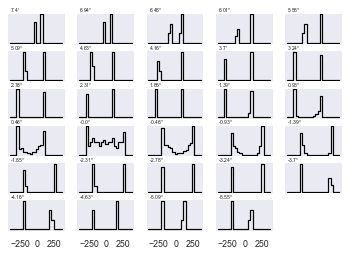

In [5]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
from scipy import stats
# Now, this part calls whatever galaxy you are running
names=['Akira_45']
for z in range(len(names)):
    name=names[z]
    
    print(name)
    
    minus_one=0
    if name =='Akira_90':
        PA_1 = 'akira_slit1_input_bin90_edited.txt'
        PA1 = 40
        pixelscale_1 = 0.15
        slitwidth = 0.75
        minus_pa_1 = 0
        spatial_resolution=0.4626
        PA_s = [PA_1]
        PA_pos = [PA1]
        minus_list = [minus_pa_1]
        cen_0 = [0,0]
        cen_list = [cen_0]
    
    
    if name =='Akira_45':
        PA_1 = 'akira_slit1_input_bin45_edited.txt'
        PA1 = 40
        pixelscale_1 = 0.15
        slitwidth = 0.75
        minus_pa_1 = 0
        spatial_resolution=0.4626
        PA_s = [PA_1]
        PA_pos = [PA1]
        minus_list = [minus_pa_1]
        cen_0 = [0,0]
        cen_list = [cen_0]
    if name=='Akira':
        PA_1 = 'akira_slit1_input.txt'
        PA_2 = 'akira_slit2_input.txt'
        PA_3 = 'akira_slit3_input.txt'
        PA1 = 40
        PA2 = 110
        PA3 = PA1
        pixelscale = 0.15 # This is arcsec per pixel
        pixelscale_1 = pixelscale
        pixelscale_2 = pixelscale
        slitwidth = 0.75 # This is arcsec
        
        minus_pa_1 = 2
        minus_pa_2 = 0
        minus_pa_3 = 0
        
        spatial_resolution = 0.4626 # This is the res in arcsec
        PA_s = [PA_1, PA_2, PA_3]
        PA_pos = [PA1, PA2, PA3]
        minus_list = [minus_pa_1, minus_pa_2, minus_pa_3]
        
        # the first two slits are centered at - RA = 136.0895, Dec = 41.4817
        # the third slit is centered at - RA = 136.0911, Dec = 41.4807,
        RA_1 = 136.0895
        dec_1 = 41.4817
        RA_2 = 136.0911
        dec_2 = 41.4807
        
        ddec = (dec_2 - dec_1)*3600
        print(ddec)
        print('difference in dec', (dec_2 + dec_1)/2)
        dRA = (RA_1 - RA_2) *3600 * np.cos(math.radians((dec_2 + dec_1)/2))
        print(dRA)
        
        cen_0 = [0,0]
        cen_1 = [0,0]
        cen_2 = [dRA, ddec] # This is relative positioning
        print('cen_2', cen_2)
        cen_list = [cen_0,cen_1, cen_2]
    
    xs_data_list, vel_data_list, error_up_list, error_down_list = load_data(PA_s, minus_list, 1000)
    
    
    
    color_list = ['#E40066','#03CEA4','#EAC435','#4C4C9D','#48639C']
    
    # This makes some diagnostic plots of the input data:
    plot_data(xs_data_list, vel_data_list, error_up_list, error_down_list, 
              PA_pos, spatial_resolution, color_list, name)
    
    # This function will use the PAs to project into x and y coordinates in arcesec
    # in order to make the new boundaries
    xs_proj, ys_proj = project_xy(cen_list, PA_pos, xs_data_list)
    

    start=datetime.datetime.now()
    z_prelim=10,40,4,40,500

    
    # So this returns an array of the corners of all the spatial bins that you
    # have in your data; it can then be used as an input to lnlike to compare with the model :)
    
    boundaries = a_function_that_computes_bounds(xs_proj, ys_proj, cen_list, PA_pos,  
                                                 slitwidth, spatial_resolution,
                                                color_list)
    
    mean_0, mean_1, mean_2, mean_3, mean_4 = [15, 33, 6, 40, 332]
    args = [boundaries,  xs_data_list, vel_data_list, error_up_list, error_down_list, 'yes', xs_proj, ys_proj, name]
    lnlike_bicone_plot_profile([mean_0, mean_1, mean_2, mean_3, mean_4], *args)
    
    
    STOP
    
    
    
    
    end=datetime.datetime.now()
    print(end-start)
    print('youve done one run')
    
    
    #`~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
    

    def lnprior(z):
        phi_array, theta_array, r_t, half_angle, vel_max_array=z
        if -90 < phi_array < 90 and 0.0 < theta_array < 359.9 and 0 < r_t < 100 and 0 < half_angle < 90 and 10 < vel_max_array < 1000:
            return 0.0
        return -np.inf
    #you also need the log likelihood function:                                                                                                                                                             
    #we already have a log likelihood function                                                                                                                                                              
    def lnprob(z, *args):
        lp=lnprior(z)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike_bicone(z, *args)
    ndim, nwalkers=5,20#was 100
    result=5,18.6,5,33.36,420
    mult=10,5,1,5,10

    #pos is the starting position for the walkers                                                                                                                                                           
    pos=[result+mult*np.random.randn(ndim) for i in range(nwalkers)]
    #print('pos', pos)                                                                                                                                                                                      

    import emcee
    start=datetime.datetime.now()
    #count=0   
    
    #a=2, threads=48,
    sampler=emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[boundaries,  xs_data_list, vel_data_list, error_up_list, error_down_list])
    #sampler=emcee.EnsembleSampler(nwalkers, ndim, lnprob,a=1.75, threads=48)
    print('You finished the prep for burn in')
    
    len_chain = 100
    pos, prob, state = sampler.run_mcmc(pos,
                                        len_chain, progress=True)
    #was 200
    end=datetime.datetime.now()
    samples_pre=sampler.chain[:,:,:]
    f_acc_pre=sampler.acceptance_fraction
    #autocorr_pre=sampler.acor
    print('f_acc burn in', f_acc_pre)
    #print('autocorr for burn in', autocorr_pre)
    print('pos after burn in', pos)
    g=open(str(name)+"/bicone/emcee_burn_0_c.txt","w")
    h=open(str(name)+"/bicone/emcee_burn_1_c.txt","w")
    k=open(str(name)+"/bicone/emcee_burn_2_c.txt","w")
    l=open(str(name)+"/bicone/emcee_burn_3_c.txt","w")
    m=open(str(name)+"/bicone/emcee_burn_4_c.txt","w")
    n=open(str(name)+"/bicone/emcee_burn_f_acc_c.txt","w")
    for i in range(nwalkers):
        for j in range(len_chain):
            g.write(str(samples_pre[i][j][0])+'\n')
            h.write(str(samples_pre[i][j][1])+'\n')
            k.write(str(samples_pre[i][j][2])+'\n')
            l.write(str(samples_pre[i][j][3])+'\n')
            m.write(str(samples_pre[i][j][4])+'\n')

    #       #n.write(str(f_acc_pre[i][j])+'\n')                                                                                                                                                             
    g.close()
    h.close()
    k.close()
    l.close()
    m.close()
    
    
    plt.clf()
    fig, axes = plt.subplots(5, figsize=(15, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["inc", "PA", "r","theta", "v"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.savefig('walkers_bicone.png')


    print(np.shape(samples_pre))
    mean_0 = np.mean(samples_pre[:][len_chain-1][0])
    mean_1 = np.mean(samples_pre[:][len_chain-1][1])
    mean_2 = np.mean(samples_pre[:][len_chain-1][2])
    mean_3 = np.mean(samples_pre[:][len_chain-1][3])
    mean_4 = np.mean(samples_pre[:][len_chain-1][4])
    print('mean variables', mean_0, mean_1, mean_2, mean_3, mean_4)
    
    # Now make a plot of the bicone from these
    
    args = [boundaries,  xs_data_list, vel_data_list, error_up_list, error_down_list, 'yes', xs_proj, ys_proj]
    lnlike_bicone([mean_0, mean_1, mean_2, mean_3, mean_4], *args)


In [ ]:
# fabled corner plot:
import corner

fig = corner.corner(
    samples_flat, labels=labels
)
plt.savefig('corner_plot_new.png')

from IPython.display import display, Math

for i in range(len_chain):
    mcmc = np.percentile(samples_flat[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
print(np.shape(samples_pre))
print(samples_pre[:,99,0])
final = 99
samples_flat = sampler.get_chain(flat=True)

params = ['inc', 'PA', 'r', 'opening', 'vmax']
for i in range(len(params)):
    plt.clf()
    fig = plt.figure(figsize=(12,2))
    ax0 = fig.add_subplot(121)
    ax0.hist(samples_flat[:, i], 20, color="k", histtype="step")
    ax0.set_xlabel(params[i])
    ax0.set_ylabel(r"$p("+params[i]+")$")
    
    ax1 = fig.add_subplot(122)
    for j in range(20):# there are 20 walkers, they walk for 50 steps
        ax1.plot(samples_pre[j,:,i])
    ax1.set_ylabel(params[i])
    ax1.set_xlabel('Steps')
    plt.show()





print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

'''print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)'''

# Now get the mean dists
for i in range(len(params)):
    print('Parameter ', params[i])
    print('Starting mean is ', np.mean(samples_pre[:,0,i]))
    print('Starting std is ',np.std(samples_pre[:,0,i]))
    
    print('Ending mean is ', np.mean(samples_pre[:,final,i]))
    print('Ending std is ',np.std(samples_pre[:,final,i]))
    
    plt.clf()
    plt.hist(samples_pre[:,0,i], 20, color="k", histtype="step", label='Starting')
    plt.hist(samples_pre[:,final,i], 20, color="r", histtype="step", label='Ending')
    plt.xlabel(params[i])
    plt.legend()
    plt.show()


-lnlike 7100.621884435163


7100.621884435163

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

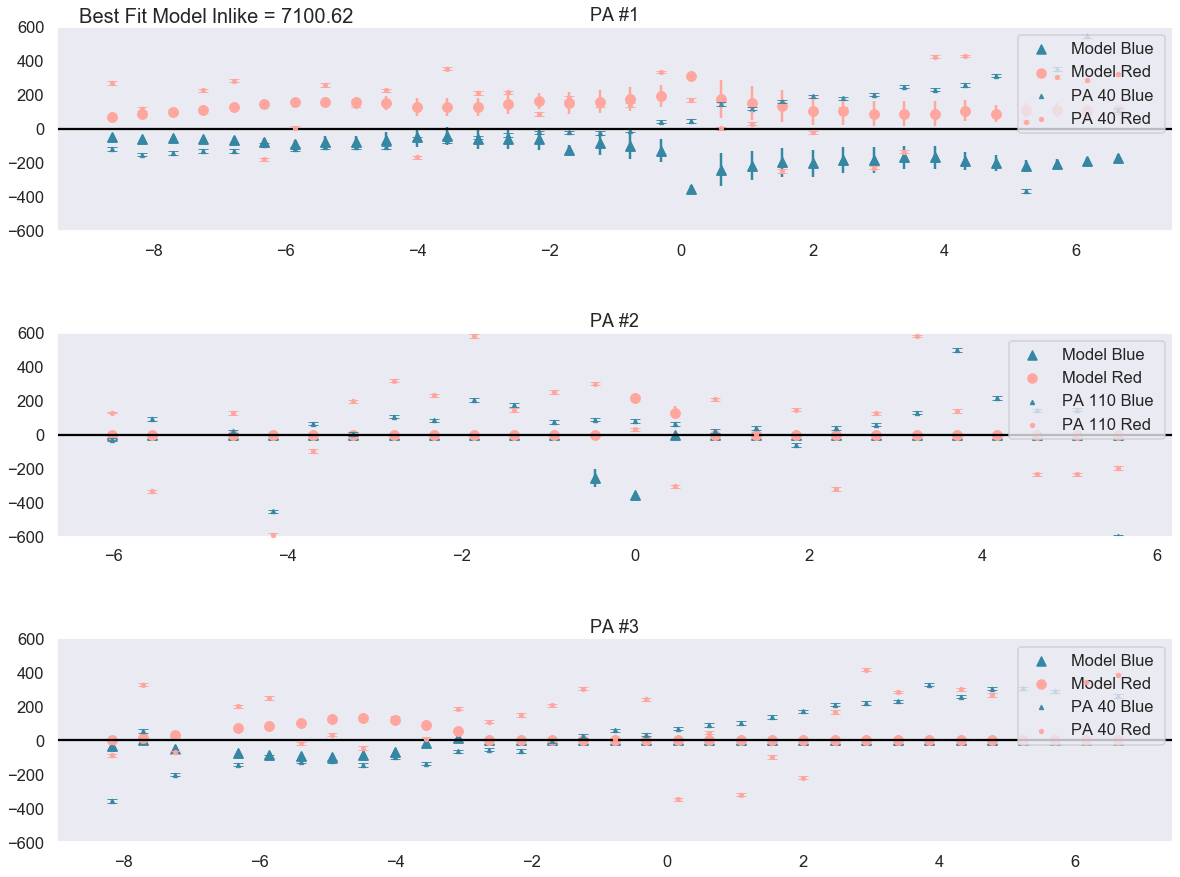

In [75]:
# Now make a plot of the bicone from these
mean_0, mean_1, mean_2, mean_3, mean_4 = [-5, 13,6, 32, 432]
args = [boundaries,  xs_data_list, vel_data_list, error_up_list, error_down_list, 'yes', xs_proj, ys_proj]
lnlike_bicone_plot([mean_0, mean_1, mean_2, mean_3, mean_4], *args)
